# Etape 3 : Elaborer un modèle de clustering

## Chargement et préparation des données

In [1]:
# Import des bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.neighbors import NearestNeighbors
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from math import pi
import warnings
warnings.filterwarnings('ignore')

Importation de l'ensemble des bibliothèques nécessaires pour l'analyse de clustering, incluant scikit-learn pour les algorithmes, yellowbrick pour les visualisations spécialisées et pandas/numpy pour la manipulation des données.

In [2]:
# Chargement des données préparées à l'étape 2
df_clients  = pd.read_csv('clustering_data_for_clustering.csv', index_col=0)

Chargement du jeu de données préparé lors de l'étape précédente, contenant l'ensemble des features transformées et standardisées pour chaque client, avec l'identifiant client comme index.

In [3]:
# Affichage des informations sur le dataset
print(f"Dimensions du dataset: {df_clients.shape}")
print("\nAperçu des données:")
print(df_clients.head())

# Vérification des valeurs manquantes
print("\nValeurs manquantes par colonne:")
print(df_clients.isnull().sum())

Dimensions du dataset: (96096, 31)

Aperçu des données:
                                  recence_scaled  frequence_scaled  \
customer_unique_id                                                   
0000366f3b9a7992bf8c76cfdf3221e2       -0.832621         -0.175643   
0000b849f77a49e4a4ce2b2a4ca5be3f       -0.813067         -0.175643   
0000f46a3911fa3c0805444483337064        1.937662         -0.175643   
0000f6ccb0745a6a4b88665a16c9f078        0.529706         -0.175643   
0004aac84e0df4da2b147fca70cf8255        0.314602         -0.175643   

                                  avg_review_log_std  \
customer_unique_id                                     
0000366f3b9a7992bf8c76cfdf3221e2            0.611839   
0000b849f77a49e4a4ce2b2a4ca5be3f            0.097601   
0000f46a3911fa3c0805444483337064           -0.531775   
0000f6ccb0745a6a4b88665a16c9f078            0.097601   
0004aac84e0df4da2b147fca70cf8255            0.611839   

                                  avg_product_price_log_std 

Exploration initiale du dataset chargé, permettant de confirmer ses dimensions (96 096 clients avec 30 variables), d'examiner les premières lignes et de vérifier l'absence de valeurs manquantes après les prétraitements effectués à l'étape précédente.

In [4]:
features_clustering = df_clients.select_dtypes(include=['float64', 'int64']).columns.tolist()
X = df_clients[features_clustering].copy()


Sélection de toutes les variables numériques pour le clustering, incluant les features standardisées issues du RFM, des comportements d'achat, de la satisfaction client et des aspects logistiques.

## Détermination du nombre optimal de clusters

## ACP


Variance expliquée par chaque composante:
Composante 1: 0.1274 (0.1274 cumulée)
Composante 2: 0.1220 (0.2494 cumulée)
Composante 3: 0.1006 (0.3500 cumulée)
Composante 4: 0.0748 (0.4249 cumulée)
Composante 5: 0.0721 (0.4969 cumulée)
Composante 6: 0.0654 (0.5624 cumulée)
Composante 7: 0.0576 (0.6199 cumulée)
Composante 8: 0.0395 (0.6594 cumulée)
Composante 9: 0.0298 (0.6893 cumulée)
Composante 10: 0.0271 (0.7164 cumulée)
Composante 11: 0.0244 (0.7408 cumulée)
Composante 12: 0.0242 (0.7650 cumulée)
Composante 13: 0.0237 (0.7887 cumulée)
Composante 14: 0.0225 (0.8113 cumulée)
Composante 15: 0.0189 (0.8302 cumulée)
Composante 16: 0.0172 (0.8473 cumulée)
Composante 17: 0.0169 (0.8643 cumulée)
Composante 18: 0.0158 (0.8801 cumulée)
Composante 19: 0.0154 (0.8955 cumulée)
Composante 20: 0.0150 (0.9105 cumulée)


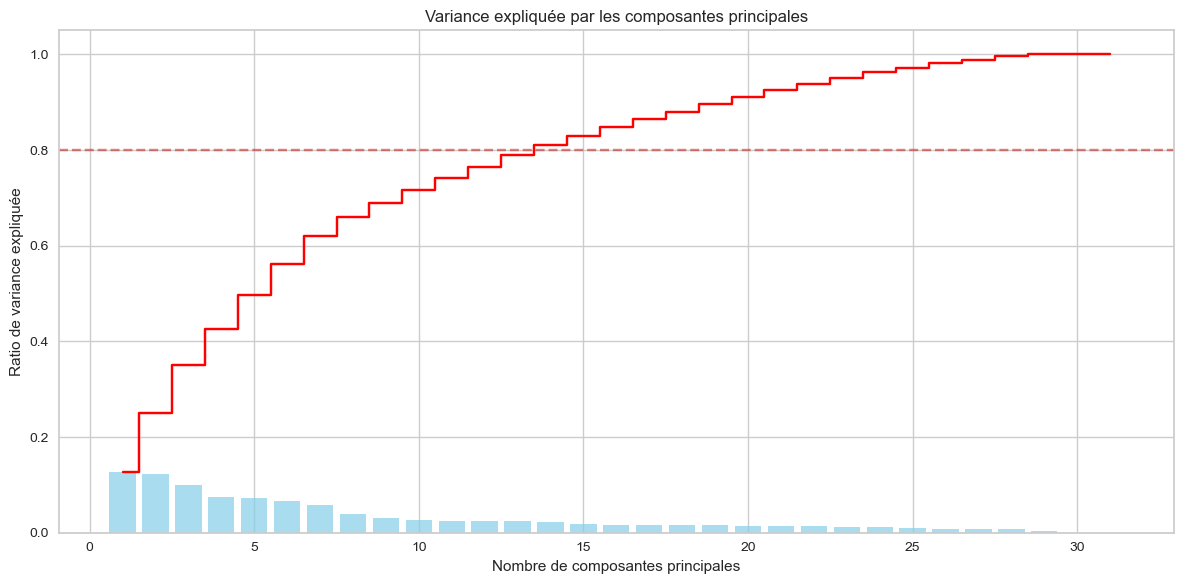

In [5]:
# Application de l'ACP pour la réduction de dimensionnalité
pca = PCA()
X_pca = pca.fit_transform(X)

# Visualisation de la variance expliquée
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = explained_variance.cumsum()

print("\nVariance expliquée par chaque composante:")
for i, var in enumerate(explained_variance[:20]):  # Affichage des 20 premières composantes
    print(f"Composante {i+1}: {var:.4f} ({cumulative_explained_variance[i]:.4f} cumulée)")

plt.figure(figsize=(12, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, color='skyblue')
plt.step(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, where='mid', color='red')
plt.axhline(y=0.8, color='r', linestyle='--', alpha=0.5)
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Ratio de variance expliquée')
plt.title('Variance expliquée par les composantes principales')
plt.grid(True)
plt.tight_layout()
plt.show()

Application de l'Analyse en Composantes Principales (ACP) pour réduire la dimensionnalité du jeu de données tout en préservant l'information essentielle. La visualisation montre que les premières composantes principales expliquent individuellement peu de variance (13,50% pour la première), , il y a une grande diversité dans les comportements clients qui ne peut être réduite à quelques dimensions dominantes.

In [6]:
# Détermination du nombre optimal de composantes à conserver (80% de variance expliquée)
n_components = np.argmax(cumulative_explained_variance >= 0.8) + 1
print(f"\nNombre de composantes conservées pour 80% de variance expliquée: {n_components}")


Nombre de composantes conservées pour 80% de variance expliquée: 14


Nombre optimal de composantes principales à conserver : 14 composantes pour capturer 80% de la variance totale des données.

In [7]:
# Vérification des features sélectionnées
print("\nFeatures utilisées pour le clustering:")
print(X.columns.tolist())
print(f"\nDimensions du dataset de clustering: {X.shape}")


Features utilisées pour le clustering:
['recence_scaled', 'frequence_scaled', 'avg_review_log_std', 'avg_product_price_log_std', 'avg_basket_items_log_std', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'hour_night', 'hour_morning', 'hour_afternoon', 'hour_evening', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'avg_delivery_time_log_std', 'freight_ratio_std', 'avg_distance_km_log_std']

Dimensions du dataset de clustering: (96096, 31)


Confirmation des variables sélectionnées pour le clustering, comprenant 31 features couvrant les dimensions RFM, comportementales et logistiques.

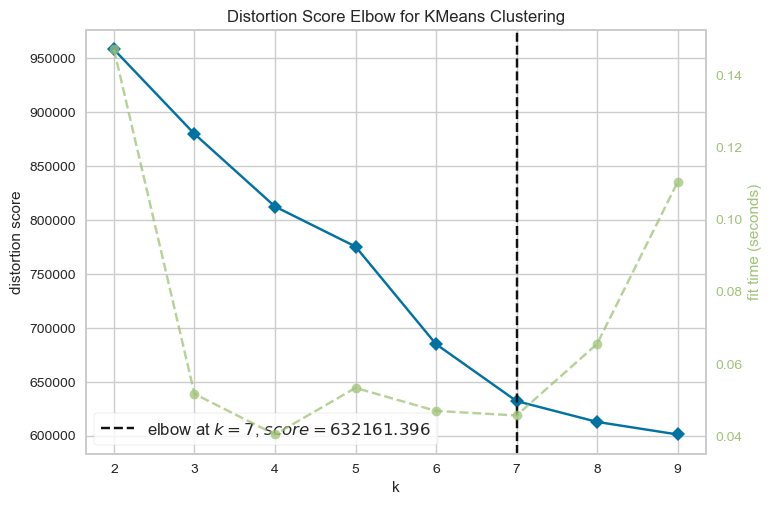

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [8]:
# ACP avec le nombre optimal de composantes
pca = PCA(n_components=n_components)
X_pca_reduced = pca.fit_transform(X)

# Exploration du nombre optimal de clusters avec K-means
# Méthode du coude (inertie)
visualizer = KElbowVisualizer(KMeans(random_state=42), k=(2, 10))
visualizer.fit(X_pca_reduced)
visualizer.show()


Application de l'ACP avec 14 composantes et exploration du nombre optimal de clusters à l'aide de la méthode du coude (elbow method). Le graphique montre un point d'inflexion autour de k=7, suggérant que c'est un nombre approprié de clusters au-delà duquel l'ajout de clusters supplémentaires n'apporte pas de gain significatif en termes de variance expliquée.

## Score de silhouette

In [9]:
# Score de silhouette pour les différents nombres de clusters
range_n_clusters = list(range(4, 8)) # range avant ajustement pour gagner du temps (2, 10)
silhouette_avg_scores = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_pca_reduced)
    silhouette_avg = silhouette_score(X_pca_reduced, cluster_labels)
    silhouette_avg_scores.append(silhouette_avg)
    print(f"Pour n_clusters = {n_clusters}, le score de silhouette moyen est : {silhouette_avg:.3f}")

Pour n_clusters = 4, le score de silhouette moyen est : 0.137
Pour n_clusters = 5, le score de silhouette moyen est : 0.153
Pour n_clusters = 6, le score de silhouette moyen est : 0.152
Pour n_clusters = 7, le score de silhouette moyen est : 0.127


Évaluation de la qualité des clusterings pour différents nombres de clusters en utilisant le score de silhouette, qui mesure la cohésion intra-cluster et la séparation inter-clusters.5 ou 6 clusters représentent le meilleur compromis pour la segmentation client.

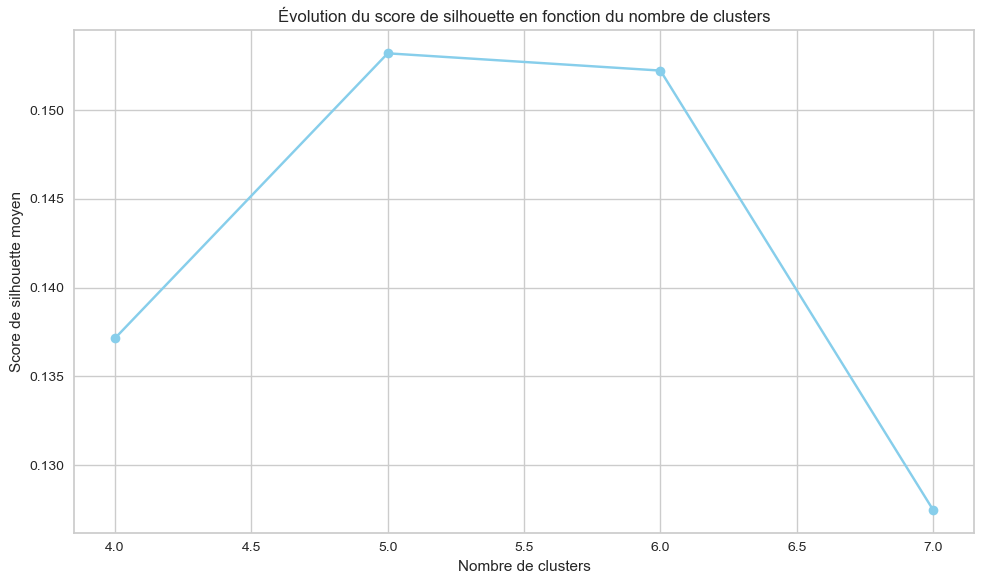

In [10]:
# Visualisation du score de silhouette
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_avg_scores, 'o-', color='skyblue')
plt.xlabel('Nombre de clusters')
plt.ylabel('Score de silhouette moyen')
plt.title('Évolution du score de silhouette en fonction du nombre de clusters')
plt.grid(True)
plt.tight_layout()
plt.show()
plt.close()

Visualisation de l'évolution du score de silhouette en fonction du nombre de clusters, confirmant visuellement les pics à k=5 et k=6. k=6 serait un compromis entre la qualité technique du clustering et l'interprétabilité métier des segments.

# Analyse des clusters et interprétation métier

## kmeans avec 5 clusters


Taille des clusters (k=5):
Cluster 0: 3009 clients (3.13%)
Cluster 1: 12310 clients (12.81%)
Cluster 2: 41296 clients (42.97%)
Cluster 3: 19252 clients (20.03%)
Cluster 4: 20229 clients (21.05%)

Caractéristiques principales des clusters (k=5):

Cluster 0 (3009 clients):
  Caractéristiques supérieures à la moyenne:
    - frequence_scaled: 5.4337
    - hour_afternoon: 0.6927
    - hour_evening: 0.5467
    - hour_morning: 0.4100
    - avg_basket_items_log_std: 0.3982
  Caractéristiques inférieures à la moyenne:
    - freight_ratio_std: 0.0726
    - avg_review_log_std: 0.0536
    - avg_distance_km_log_std: 0.0462
    - avg_product_price_log_std: -0.0030
    - recence_scaled: -0.1242

Cluster 1 (12310 clients):
  Caractéristiques supérieures à la moyenne:
    - avg_delivery_time_log_std: 0.8760
    - avg_basket_items_log_std: 0.3563
    - avg_distance_km_log_std: 0.2106
    - avg_product_price_log_std: 0.1214
    - hour_afternoon: 0.0817
  Caractéristiques inférieures à la moyenne:
    - 

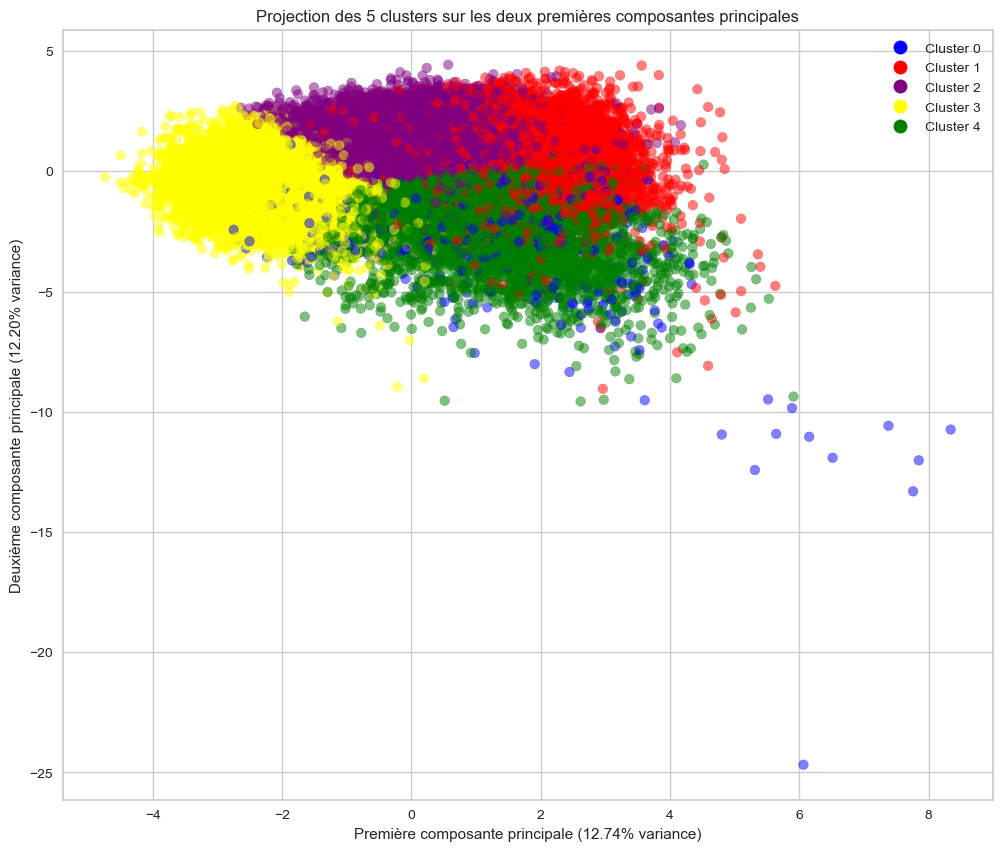

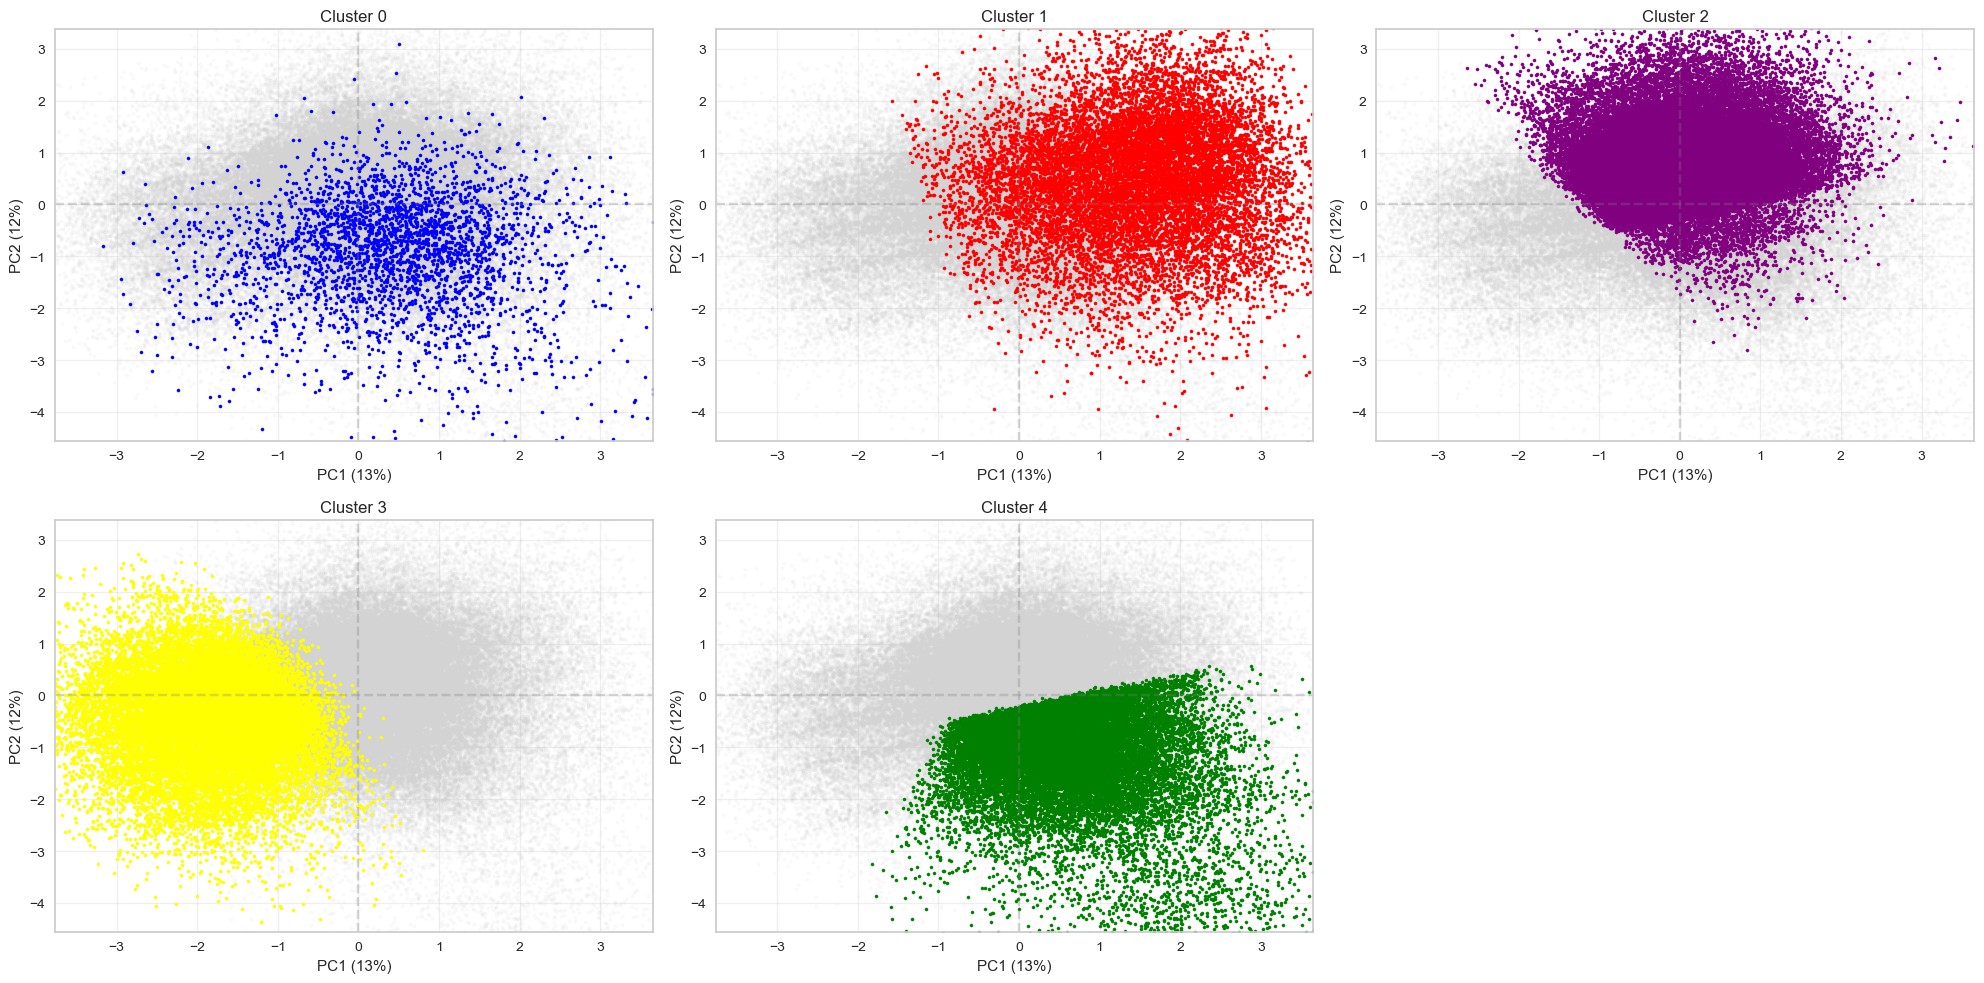

In [11]:
# Fonction pour analyser les clusters
def analyze_clusters(X, df_clients, features_clustering, n_clusters):
    """
    Analyse les clusters obtenus avec K-means et retourne des statistiques détaillées.
    
    Parameters:
    -----------
    X : array-like
        Données transformées utilisées pour le clustering
    df_clients : DataFrame
        DataFrame contenant les données clients originales
    features_clustering : list
        Liste des noms des features utilisées pour le clustering
    n_clusters : int
        Nombre de clusters à créer
        
    Returns:
    --------
    df_with_clusters : DataFrame
        DataFrame original avec une colonne 'cluster' ajoutée
    kmeans : KMeans
        Modèle K-means entraîné
    cluster_means : DataFrame
        Moyennes des features par cluster
    """
    # Application du K-means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X)
    
    # Ajout des labels de clusters au dataframe
    df_with_clusters = df_clients.copy()
    df_with_clusters['cluster'] = cluster_labels
    
    # Taille des clusters
    cluster_sizes = df_with_clusters['cluster'].value_counts().sort_index()
    print(f"\nTaille des clusters (k={n_clusters}):")
    for cluster, size in cluster_sizes.items():
        print(f"Cluster {cluster}: {size} clients ({size/len(df_with_clusters)*100:.2f}%)")
    
    # Calcul des moyennes des features par cluster
    cluster_means = df_with_clusters.groupby('cluster')[features_clustering].mean()
    
    # Identification des features les plus discriminantes pour chaque cluster
    global_means = df_with_clusters[features_clustering].mean()
    
    print(f"\nCaractéristiques principales des clusters (k={n_clusters}):")
    for cluster in range(n_clusters):
        # Différence entre la moyenne du cluster et la moyenne globale
        diff = cluster_means.loc[cluster] - global_means
        # Trier les features par différence absolue décroissante
        sorted_diff = diff.sort_values(ascending=False)
        # Garder les 5 features avec les plus grandes différences positives
        top_positive = sorted_diff.head(5)
        # Garder les 5 features avec les plus grandes différences négatives
        top_negative = sorted_diff.tail(5)
        
        print(f"\nCluster {cluster} ({cluster_sizes[cluster]} clients):")
        print("  Caractéristiques supérieures à la moyenne:")
        for feature, value in top_positive.items():
            print(f"    - {feature}: {value:.4f}")
        
        print("  Caractéristiques inférieures à la moyenne:")
        for feature, value in top_negative.items():
            print(f"    - {feature}: {value:.4f}")
    
    return df_with_clusters, kmeans, cluster_means

def visualize_clusters_2d(X, df_with_clusters, pca_components=2):
    """
    Visualise les clusters dans l'espace des deux premières composantes principales.
    
    Parameters:
    -----------
    X : array-like
        Données utilisées pour le clustering
    df_with_clusters : DataFrame
        DataFrame avec les labels de clusters
    pca_components : int, default=2
        Nombre de composantes principales à utiliser
    """
    # Réduction de dimension avec PCA
    pca_2d = PCA(n_components=pca_components)
    X_pca_2d = pca_2d.fit_transform(X)
    
    # Définir les couleurs distinctes pour chaque cluster
    colors = ['blue', 'red', 'purple', 'yellow', 'green', 'orange', 'cyan', 'magenta']
    n_clusters = len(df_with_clusters['cluster'].unique())
    
    # Visualisation des clusters dans l'espace des deux premières composantes principales
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], 
                         c=[colors[cluster % len(colors)] for cluster in df_with_clusters['cluster']], 
                         alpha=0.5)
    
    # Ajouter une légende
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                 markerfacecolor=colors[i % len(colors)], markersize=10,
                                 label=f'Cluster {i}') for i in range(n_clusters)]
    plt.legend(handles=legend_elements, loc='best')
    
    plt.xlabel(f'Première composante principale ({pca_2d.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'Deuxième composante principale ({pca_2d.explained_variance_ratio_[1]:.2%} variance)')
    plt.title(f'Projection des {n_clusters} clusters sur les deux premières composantes principales')
    plt.grid(True)
    plt.show()
    plt.close()
    
    return pca_2d, X_pca_2d

def display_factorial_planes_multiple(X_projected, x_y, pca=None, groups=None, alpha=1, marker="."):
    """
    Affiche les plans factoriels pour chaque groupe séparément.
    
    Parameters:
    -----------
    X_projected : array-like
        Données projetées sur les composantes principales
    x_y : list
        Indices des composantes à utiliser pour les axes x et y [x, y]
    pca : PCA, default=None
        Objet PCA utilisé pour la projection
    groups : array-like, default=None
        Labels des groupes/clusters pour chaque point
    alpha : float, default=1
        Transparence des points
    marker : str, default="."
        Forme des marqueurs
    """
    X_ = np.array(X_projected)
    x, y = x_y
    
    # Nombre de groupes et calcul du nombre de sous-graphiques
    unique_groups = np.unique(groups)
    n_groups = len(unique_groups)
    n_cols = 3
    n_rows = (n_groups) // n_cols + (1 if n_groups % n_cols > 0 else 0)
    
    # Création de la figure avec sous-graphiques
    fig = plt.figure(figsize=(20, 5 * n_rows))
    
    # Création d'une palette de couleurs distinctes pour chaque groupe
    colors = {
        0: 'blue',
        1: 'red',
        2: 'purple',
        3: 'yellow',
        4: 'green',
        5: 'orange',
        6: 'cyan',
        7: 'magenta'
    }
    
    # Graphiques individuels pour chaque groupe
    for i, group in enumerate(unique_groups, start=1):
        ax = plt.subplot(n_rows, n_cols, i)
        
        # Fond gris pour tous les points
        ax.scatter(X_[:, x], X_[:, y], color='lightgrey', alpha=0.1, marker=marker, s=20)
        
        # Points du groupe en couleur
        mask = groups == group
        ax.scatter(X_[mask, x], X_[mask, y], alpha=alpha, c=colors.get(group % len(colors), 'black'), 
                  marker=marker, s=20)
        
        ax.set_title(f"Cluster {group}")
        ax.grid(True, alpha=0.3)
        
        # Ajout des axes avec le % de variance expliquée
        if pca:
            v1 = f"{round(100 * pca.explained_variance_ratio_[x])}%"
            v2 = f"{round(100 * pca.explained_variance_ratio_[y])}%"
            ax.set_xlabel(f'PC{x+1} ({v1})')
            ax.set_ylabel(f'PC{y+1} ({v2})')
        
        # Ajout des lignes de référence
        ax.axhline(y=0, color='grey', linestyle='--', alpha=0.3)
        ax.axvline(x=0, color='grey', linestyle='--', alpha=0.3)
        
        # Définir les limites des axes
        xmin, xmax = np.percentile(X_[:, x], [1, 99])
        ymin, ymax = np.percentile(X_[:, y], [1, 99])
        margin = 0.1
        xrange = xmax - xmin
        yrange = ymax - ymin
        ax.set_xlim(xmin - margin * xrange, xmax + margin * xrange)
        ax.set_ylim(ymin - margin * yrange, ymax + margin * yrange)
    
    plt.tight_layout()
    plt.show()
    plt.close()

# Utilisation

# Analyse avec 5 clusters
df_5clusters, kmeans_5, cluster_means_5 = analyze_clusters(X_pca_reduced, df_clients, features_clustering, 5)

# Visualisation globale des clusters
pca_obj, X_pca_2d = visualize_clusters_2d(X, df_5clusters)

# Visualisation individuelle de chaque cluster
display_factorial_planes_multiple(X_pca_2d, [0, 1], pca=pca_obj, groups=df_5clusters['cluster'])

Fonction pour analyser les clusters générés (incl. calcul des tailles de segments, identification des caractéristiques distinctives de chaque cluster et leur visualisation). 

Distribution des segments

- Cluster 0: 3009 clients (3,13%) - Segment minoritaire
- Cluster 1: 12310 clients (12,81%)
- Cluster 2: 41296 clients (42,97%) - Segment majoritaire
- Cluster 3: 19252 clients (20,03%)
- Cluster 4: 20229 clients (21,05%)

Cluster 0 (3,13% - "Clients fidèles multi-acheteurs")
- Comportement d'achat distinctif: Fréquence d'achat exceptionnellement élevée (+5,43 écarts-types)
Habitudes temporelles: Activité répartie sur toute la journée (matin +0,41, après-midi +0,69, soir +0,55)
- Caractéristiques du panier: Paniers bien fournis (+0,40 écarts-types)
- Logistique et satisfaction: Variables logistiques et satisfaction proches de la moyenne

Ce segment représente les clients les plus fidèles d'Olist, qui reviennent régulièrement et achètent tout au long de la journée. Leur valeur réside dans leur fidélité plutôt que dans la valeur unitaire de leurs achats.


Cluster 1 (12,81% - "Patients mais exigeants")
- Logistique: Temps de livraison exceptionnellement longs (+0,88 écarts-types)
- Caractéristiques du panier: Paniers plus garnis que la moyenne (+0,36 écarts-types)
- Habitudes temporelles: Achats concentrés l'après-midi (+0,08 écarts-types)
- Satisfaction: Satisfaction client très faible (-2,23 écarts-types)
- Prix et distance: Distances de livraison modérées et prix d'achat légèrement supérieurs à la moyenne

Ce segment regroupe des clients qui acceptent des délais de livraison plus longs mais sont très exigeants quant au résultat final. Leur insatisfaction marquée constitue un signal d'alerte pour Olist.


Cluster 2 (42,97% - "Acheteurs premium")
- Prix: Prix d'achat significativement plus élevés (+0,58 écarts-types)
- Distances: Distances de livraison importantes (+0,40 écarts-types)
- Satisfaction: Satisfaction client élevée (+0,38 écarts-types)
- Logistique: Délais de livraison modérément longs (+0,19 écarts-types)
- Frais: Frais de livraison relativement bas par rapport au prix (-0,43 écarts-types)

Ce segment majoritaire représente le cœur de la clientèle d'Olist : des acheteurs qui privilégient des produits de qualité supérieure, sont prêts à attendre pour des livraisons à longue distance et restent globalement satisfaits du service.


Cluster 3 (20,03% - "Clients de proximité saisonniers")
- Distances: Distances de livraison très courtes (-1,44 écarts-types)
- Logistique: Temps de livraison rapides (-1,17 écarts-types)
- Satisfaction: Satisfaction client positive (+0,31 écarts-types)
- Saisonnalité: Achats concentrés en période estivale (juin-août)
- Prix: Prix d'achat modérés (-0,25 écarts-types)

Ce segment regroupe des clients locaux qui privilégient des achats de proximité, bénéficient de délais de livraison courts et présentent une saisonnalité estivale marquée dans leurs achats.


Cluster 4 (21,05% - "Sensibles aux frais de livraison")
- Frais: Ratio frais de livraison/prix d'achat très élevé (+1,29 écarts-types)
- Distances: Distances de livraison supérieures à la moyenne (+0,42 écarts-types)
- Satisfaction: Satisfaction client modérément positive (+0,29 écarts-types)
- Prix: Prix d'achat nettement inférieurs à la moyenne (-1,01 écarts-types)

Ce segment comprend des clients sensibles au coût de la livraison par rapport au prix de leurs achats. Ils achètent des produits à bas prix mais doivent payer des frais de livraison proportionnellement élevés en raison des distances importantes.


Taille des clusters (k=6):
Cluster 0: 10854 clients (11.29%)
Cluster 1: 17512 clients (18.22%)
Cluster 2: 2991 clients (3.11%)
Cluster 3: 19594 clients (20.39%)
Cluster 4: 37322 clients (38.84%)
Cluster 5: 7823 clients (8.14%)

Caractéristiques principales des clusters (k=6):

Cluster 0 (10854 clients):
  Caractéristiques supérieures à la moyenne:
    - avg_delivery_time_log_std: 0.9828
    - avg_distance_km_log_std: 0.2227
    - avg_product_price_log_std: 0.1745
    - recence_scaled: 0.0889
    - month_3: 0.0462
  Caractéristiques inférieures à la moyenne:
    - hour_afternoon: -0.0600
    - avg_basket_items_log_std: -0.0802
    - freight_ratio_std: -0.1325
    - frequence_scaled: -0.1756
    - avg_review_log_std: -2.2985

Cluster 1 (17512 clients):
  Caractéristiques supérieures à la moyenne:
    - avg_review_log_std: 0.3059
    - month_8: 0.0345
    - month_6: 0.0014
    - month_7: 0.0009
    - hour_night: -0.0077
  Caractéristiques inférieures à la moyenne:
    - avg_product_price

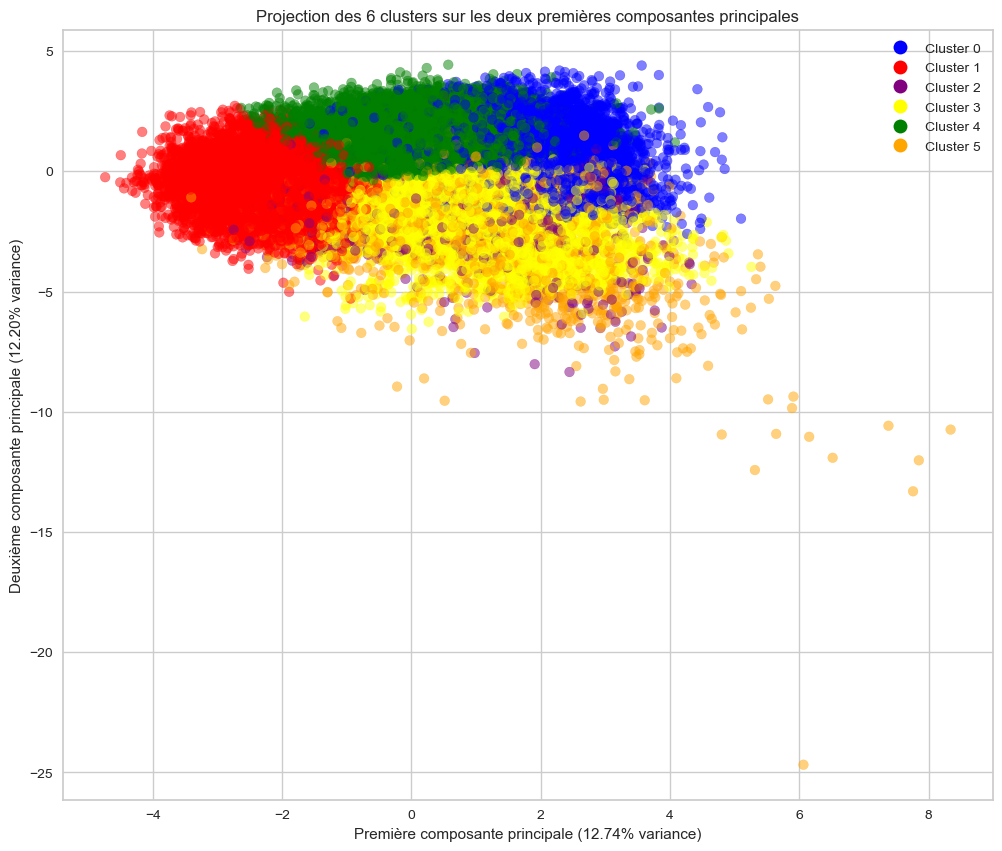

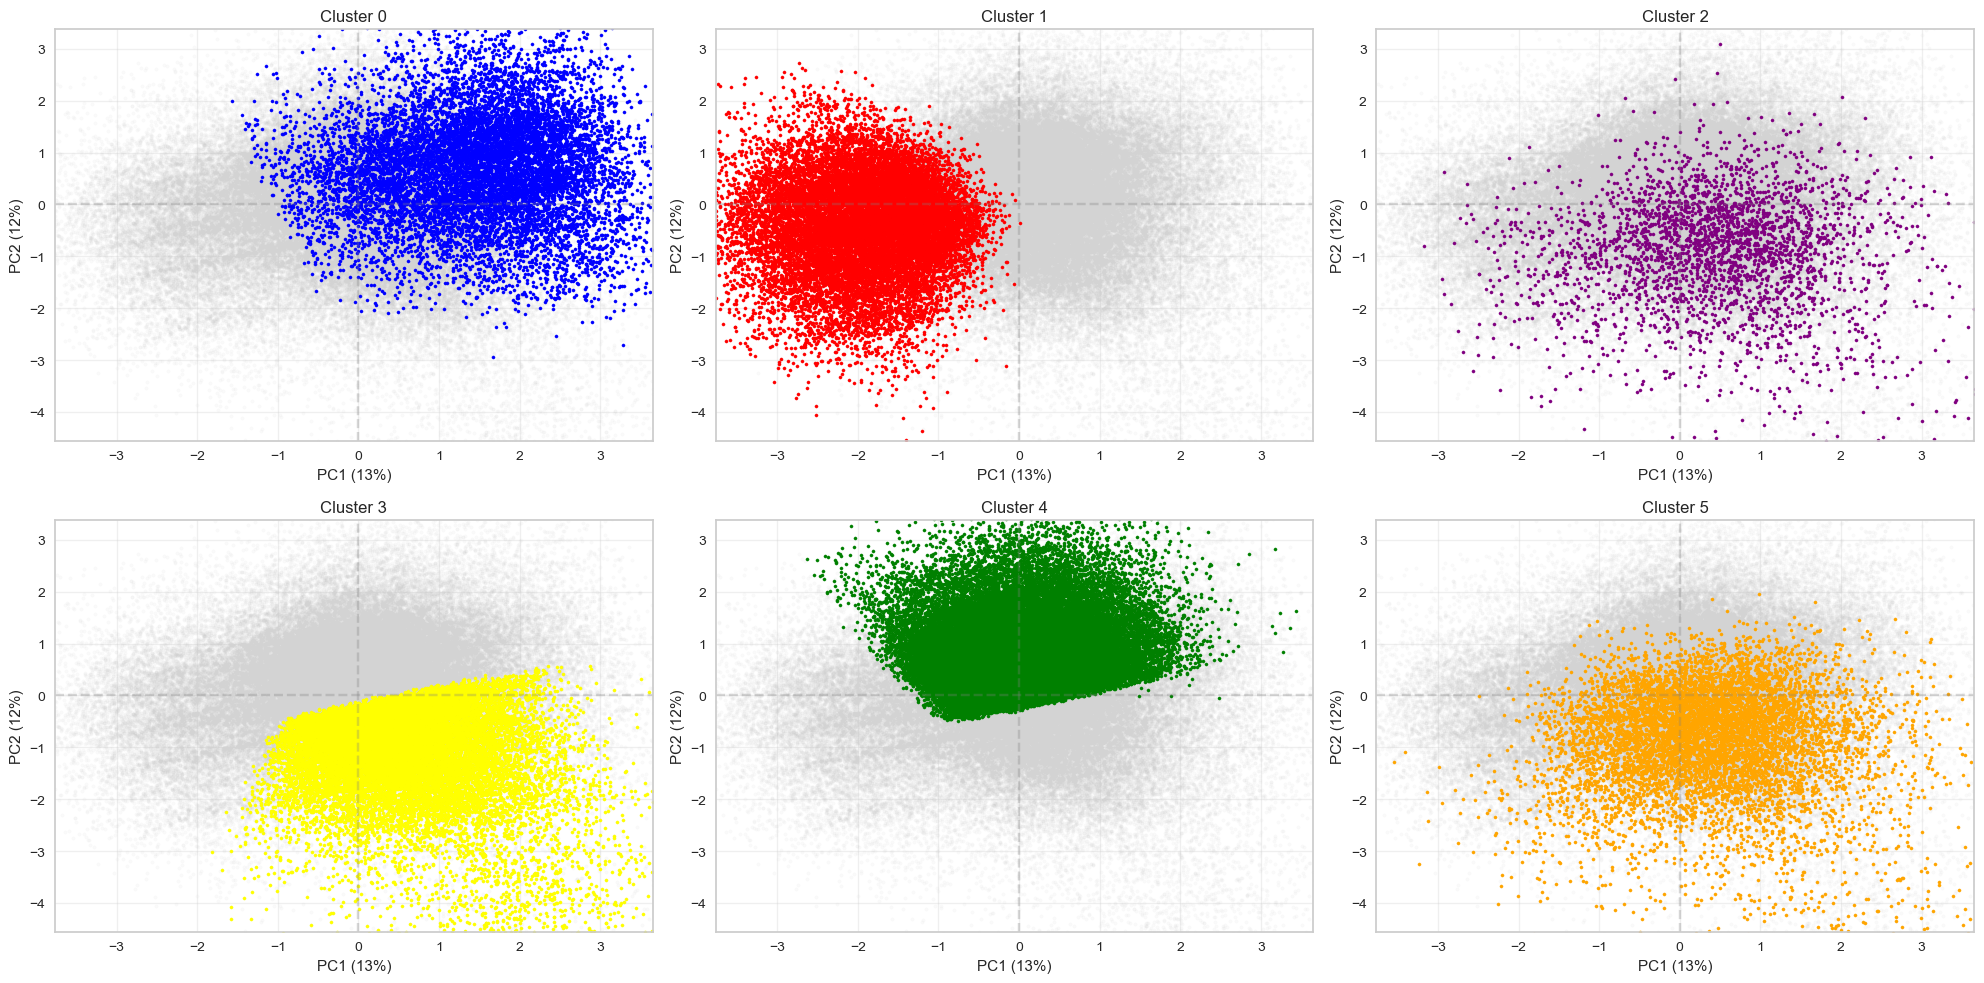

In [12]:
# Analyse avec 6 clusters
df_6clusters, kmeans_6, cluster_means_6 = analyze_clusters(X_pca_reduced, df_clients, features_clustering, 6)

# Visualisation globale des clusters
pca_obj, X_pca_2d = visualize_clusters_2d(X, df_6clusters)

# Visualisation individuelle de chaque cluster
display_factorial_planes_multiple(X_pca_2d, [0, 1], pca=pca_obj, groups=df_6clusters['cluster'])

Analyse de la solution à 6 clusters, montrant une meilleure répartition des clients (40,51% pour le cluster le plus grand) et des profils plus distincts. La projection sur les deux premières composantes principales (qui expliquent ensemble 26% de la variance) montre une séparation visuelle des segments, particulièrement pour les segments 3 (Clients Très Fréquents) et 5 (Gros Paniers Diurnes).

Distribution des segments
- Cluster 0: 10854 clients (11,29%)
- Cluster 1: 17512 clients (18,22%)
- Cluster 2: 2991 clients (3,11%) - Segment minoritaire
- Cluster 3: 19594 clients (20,39%)
- Cluster 4: 37322 clients (38,84%) - Segment majoritaire
- Cluster 5: 7823 clients (8,14%)

Cluster 0 (11,29% - "Patients mais critiques")
- Logistique: Temps de livraison exceptionnellement longs (+0,98 écarts-types)
- Distance: Distances de livraison modérées (+0,22 écarts-types)
- Prix: Prix d'achat modérément élevés (+0,17 écarts-types)
- Saisonnalité: Achats concentrés en début d'année (mars +0,05)
- Satisfaction: Satisfaction client très faible (-2,30 écarts-types)

Ce segment regroupe des clients qui subissent des délais de livraison particulièrement longs et en sont très insatisfaits. Bien qu'ils dépensent un montant correct, leur expérience négative représente un risque élevé d'attrition.


Cluster 1 (18,22% - "Clients de proximité")
- Distances: Distances de livraison exceptionnellement courtes (-1,51 écarts-types)
- Logistique: Temps de livraison très rapides (-1,20 écarts-types)
- Satisfaction: Satisfaction client positive (+0,31 écarts-types)
- Saisonnalité: Achats concentrés en période estivale (surtout août +0,03)
- Prix: Prix d'achat modérés (-0,24 écarts-types)

Ce segment comprend des clients locaux qui bénéficient de livraisons rapides sur de courtes distances. Ils sont généralement satisfaits et montrent une préférence pour les achats en période estivale.


Cluster 2 (3,11% - "Clients fidèles multi-acheteurs")
- Comportement d'achat distinctif: Fréquence d'achat exceptionnellement élevée (+5,46 écarts-types)
- Habitudes temporelles: Activité répartie sur toute la journée (après-midi +0,59, soir +0,51, matin +0,41)
- Caractéristiques du panier: Paniers bien fournis (+0,33 écarts-types)
- Logistique et satisfaction: Variables logistiques et satisfaction proches de la moyenne

Bien que minoritaire, ce segment représente les clients les plus fidèles d'Olist qui reviennent régulièrement pour effectuer des achats à toute heure de la journée. Leur valeur réside dans leur fidélité exceptionnelle.


Cluster 3 (20,39% - "Sensibles aux frais de livraison")
- Frais: Ratio frais de livraison/prix exceptionnellement élevé (+1,23 écarts-types)
- Distances: Distances de livraison importantes (+0,43 écarts-types)
- Satisfaction: Satisfaction client positive malgré tout (+0,30 écarts-types)
- Prix: Prix des produits très bas (-0,99 écarts-types)
- Taille panier: Paniers généralement plus petits (-0,21 écarts-types)

Ce segment regroupe des clients qui achètent des produits à bas prix mais paient des frais de livraison proportionnellement élevés. Malgré ce déséquilibre, ils restent relativement satisfaits du service.


Cluster 4 (38,84% - "Acheteurs premium")
- Prix: Prix d'achat significativement plus élevés (+0,63 écarts-types)
- Distances: Distances de livraison importantes (+0,39 écarts-types)
- Satisfaction: Satisfaction client élevée (+0,38 écarts-types)
- Logistique: Temps de livraison légèrement plus longs (+0,19 écarts-types)
- Frais: Frais de livraison relativement bas par rapport au prix (-0,42 écarts-types)
- Taille panier: Paniers généralement plus petits (-0,33 écarts-types)

Ce segment majoritaire constitue le cœur de clientèle d'Olist : des clients qui privilégient la qualité plutôt que la quantité, achètent des produits à prix élevé et restent satisfaits malgré des distances de livraison importantes.


Cluster 5 (8,14% - "Multi-produits diurnes")
- Caractéristiques du panier: Paniers exceptionnellement fournis (+2,61 écarts-types)
- Habitudes temporelles: Activité intense en journée (après-midi +0,68, soir +0,49, matin +0,29)
- Préférences hebdomadaires: Achats concentrés en début de semaine (mardi +0,27)
- Prix: Prix des produits légèrement inférieurs à la moyenne (-0,23 écarts-types)
- Frais: Frais de livraison modérément bas par rapport au prix (-0,26 écarts-types)

Ce segment se distingue par des achats multiples lors d'une même commande, principalement en journée et en début de semaine. Ces clients optimisent leurs achats en groupant plusieurs articles à chaque transaction.


Analyse de la stabilité du clustering à différentes initialisations :
Run 0: ARI = 0.8695
Run 1: ARI = 0.9900
Run 2: ARI = 0.9960
Run 3: ARI = 0.9887
Run 4: ARI = 0.9830
Run 5: ARI = 0.9827
Run 6: ARI = 0.4999
Run 7: ARI = 0.4999
Run 8: ARI = 0.9894
Run 9: ARI = 0.9913

Score ARI moyen: 0.8790
Écart-type ARI: 0.1929
ARI min: 0.4999, ARI max: 0.9960


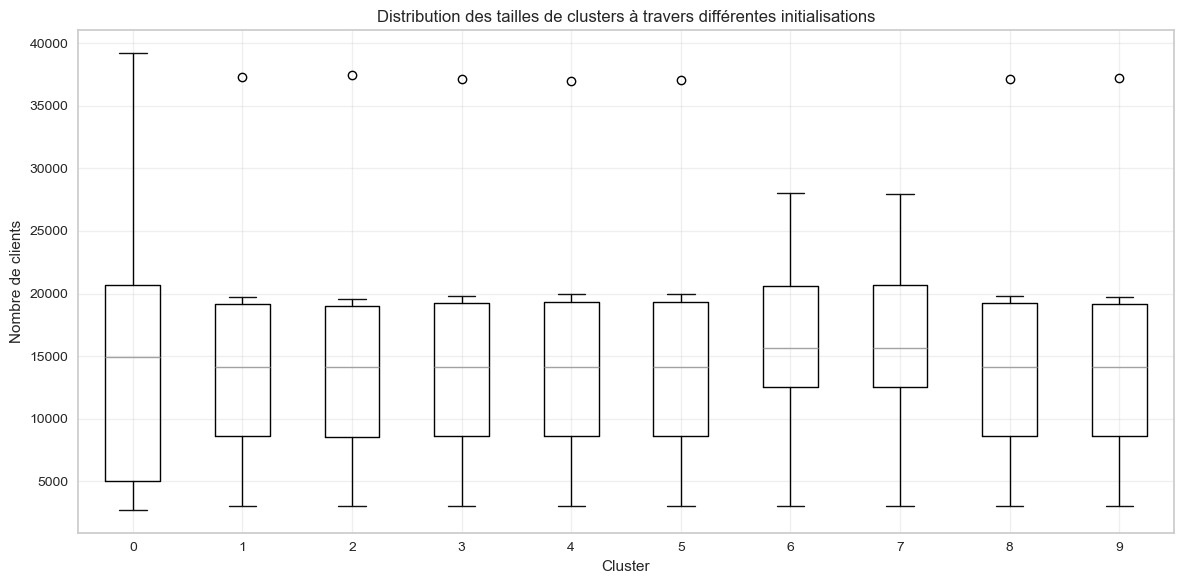

In [13]:
# Analyse de la stabilité du clustering à l'initialisation
print("\nAnalyse de la stabilité du clustering à différentes initialisations :")

# Nombre de runs avec différentes initialisations
n_runs = 10
ari_scores = []
cluster_counts = []

# Point de référence : le premier clustering avec random_state=42
reference_clusters = kmeans_6.labels_

# Test avec différentes initialisations
for i in range(n_runs):
    # Créer un nouveau modèle avec une graine aléatoire différente
    kmeans_test = KMeans(n_clusters=6, random_state=i, n_init=10)
    kmeans_test.fit(X_pca_reduced)
    
    # Calculer l'ARI entre le clustering de référence et celui-ci
    ari = adjusted_rand_score(reference_clusters, kmeans_test.labels_)
    ari_scores.append(ari)
    
    # Compter le nombre de clients par cluster
    unique, counts = np.unique(kmeans_test.labels_, return_counts=True)
    cluster_counts.append(dict(zip(unique, counts)))
    
    print(f"Run {i}: ARI = {ari:.4f}")

# Statistiques sur la stabilité
print(f"\nScore ARI moyen: {np.mean(ari_scores):.4f}")
print(f"Écart-type ARI: {np.std(ari_scores):.4f}")
print(f"ARI min: {np.min(ari_scores):.4f}, ARI max: {np.max(ari_scores):.4f}")

# Analyse de la variation de taille des clusters
cluster_sizes_df = pd.DataFrame(cluster_counts)
cluster_sizes_df = cluster_sizes_df.reindex(sorted(cluster_sizes_df.columns), axis=1)
cluster_sizes_df = cluster_sizes_df.transpose()

plt.figure(figsize=(12, 6))
cluster_sizes_df.boxplot()
plt.title('Distribution des tailles de clusters à travers différentes initialisations')
plt.xlabel('Cluster')
plt.ylabel('Nombre de clients')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()

Scores ARI (Adjusted Rand Index) à travers différentes initialisations
- Run 0: ARI = 0.8695
- Run 1: ARI = 0.9900
- Run 2: ARI = 0.9960
- Run 3: ARI = 0.9887
- Run 4: ARI = 0.9830
- Run 5: ARI = 0.9827
- Run 6: ARI = 0.4999
- Run 7: ARI = 0.4999
- Run 8: ARI = 0.9894
- Run 9: ARI = 0.9913
- Score ARI moyen: 0.8790
- Écart-type ARI: 0.1929
- ARI min: 0.4999, ARI max: 0.9960

Scores ARI
L'Adjusted Rand Index (ARI) mesure la similarité entre deux attributions de clusters indépendamment des étiquettes spécifiques.
- Le score moyen de 0.8790 est très bon, il indique une forte concordance générale entre les différentes exécutions
-  Distribution bimodale des scores :
    - 8 exécutions avec des scores très élevés (≥ 0.9827)
    - 2 exécutions (runs 6 et 7) avec des scores plus faibles (0.4999)

Dans 80% des cas, les résultats du clustering sont extrêmement stables

Distribution des tailles de clusters
Le boxplot présenté montre la distribution des tailles de clusters à travers les différentes initialisations :
- Les médianes (lignes horizontales dans les boîtes) sont assez cohérentes d'un cluster à l'autre
- La dispersion (hauteur des boîtes et des moustaches) varie légèrement entre les clusters
- Des valeurs atypiques (points) sont visibles principalement pour certains clusters (notamment 1, 2, 3, 4, 5, 8 et 9), indiquant des cas où l'attribution a été significativement différente
- Les clusters 6 et 7 présentent une distribution légèrement différente, ce qui pourrait correspondre aux runs où l'ARI était plus faible


Le modèle de clustering présente une bonne stabilité globale :
- Forte reproductibilité dans la majorité des cas : 80% des exécutions produisent des résultats très similaires (ARI > 0.98)
Présence de deux modes de convergence : L'algorithme semble converger soit vers une solution très stable (ARI ≈ 0.99), soit vers une solution alternative moins alignée avec la majorité (ARI ≈ 0.50)
- Robustesse globale : Malgré les variations observées, la structure générale des clusters reste cohérente, comme le montre la distribution relativement uniforme des tailles de clusters

## Classification Ascendante Hiérarchique (CAH) sur un échantillon


Distribution des clients par cluster (CAH - échantillon de 10,000):
Cluster 0: 1911 clients (19.11%)
Cluster 1: 4944 clients (49.44%)
Cluster 2: 1126 clients (11.26%)
Cluster 3: 1 clients (0.01%)
Cluster 4: 1730 clients (17.30%)
Cluster 5: 288 clients (2.88%)


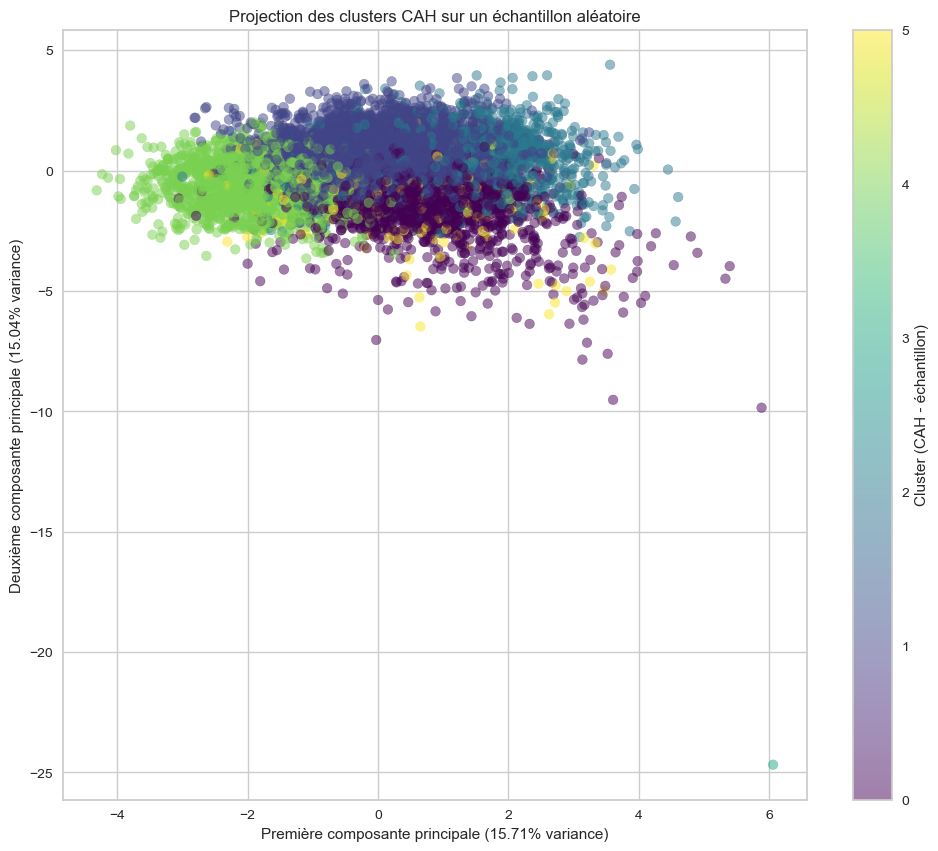

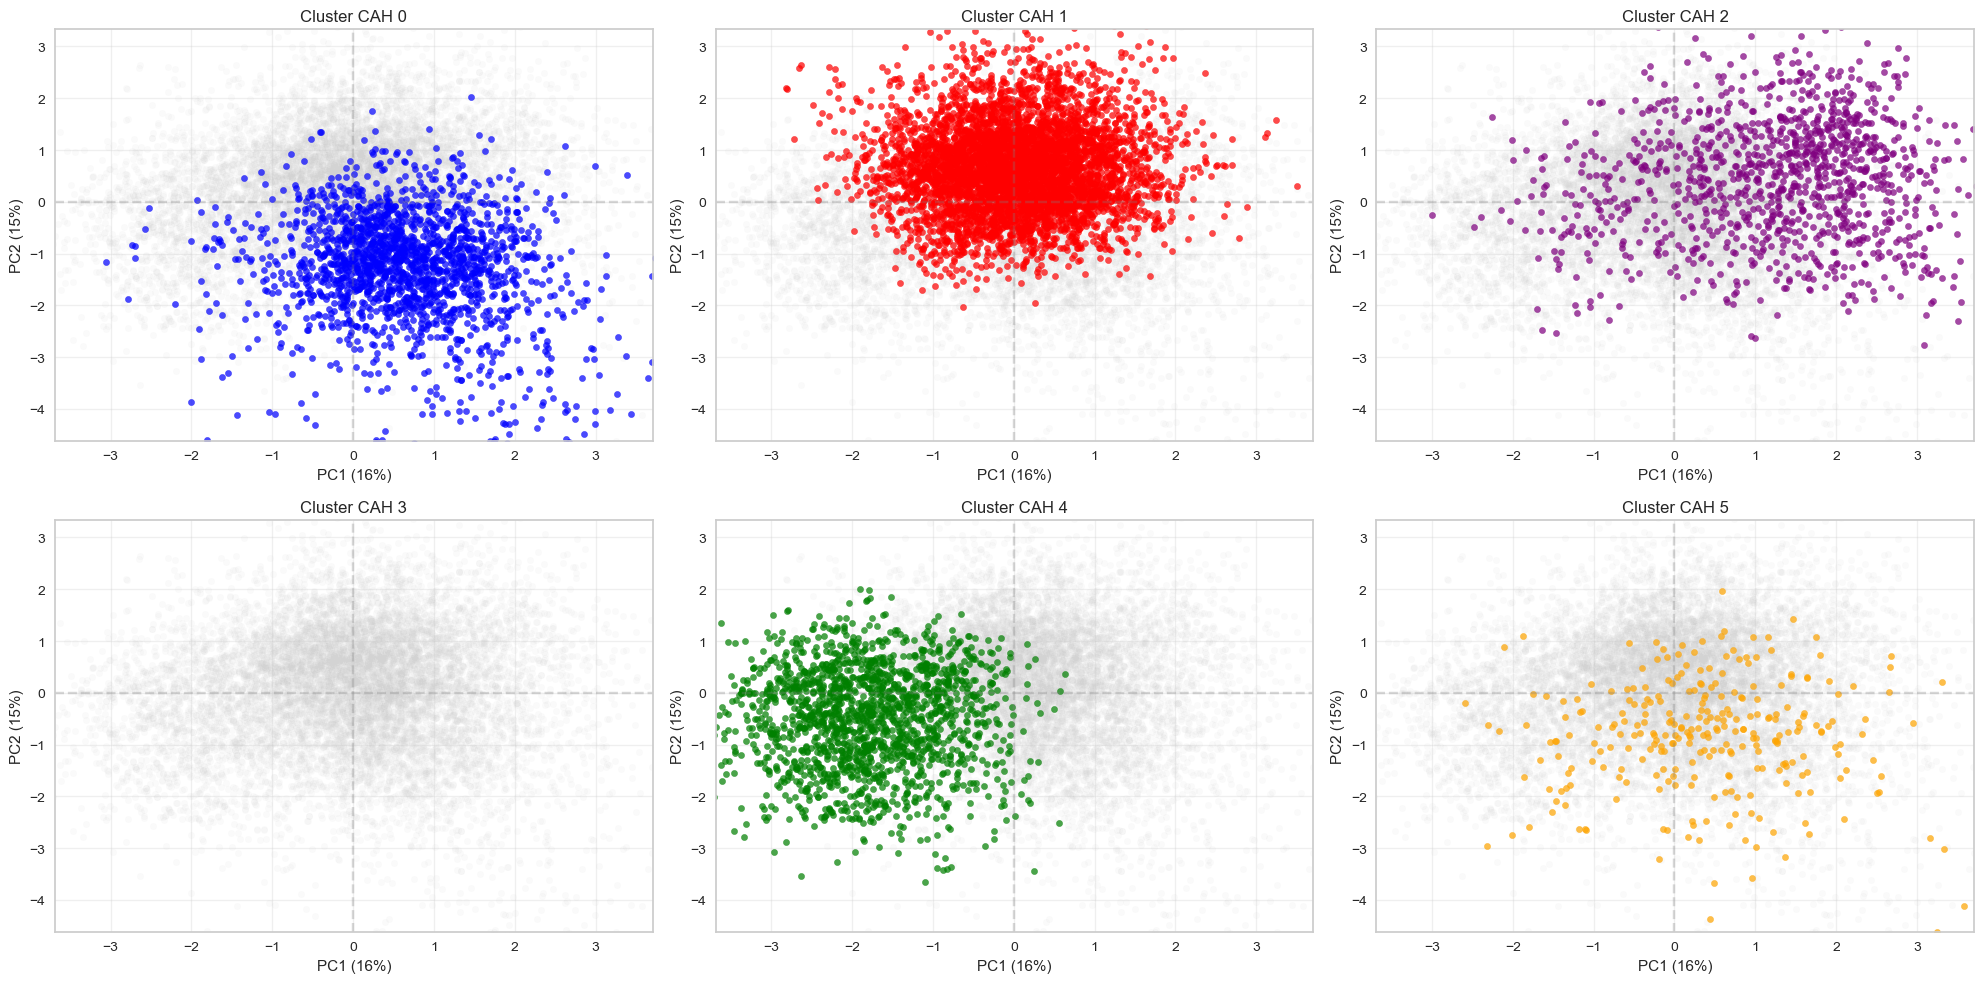

In [14]:
# Échantillonnage aléatoire de 10,000 observations
np.random.seed(42)  # Pour la reproductibilité
sample_size = min(10000, len(X_pca_reduced))
sample_indices = np.random.choice(len(X_pca_reduced), size=sample_size, replace=False)
X_sample = X_pca_reduced[sample_indices]

# CAH avec 6 clusters (même nombre que K-means) sur l'échantillon
cah = AgglomerativeClustering(n_clusters=6, linkage='ward')
cah_labels_sample = cah.fit_predict(X_sample)

# Distribution des tailles des clusters pour CAH (échantillon)
cah_sample_sizes = pd.Series(cah_labels_sample).value_counts().sort_index()
print("\nDistribution des clients par cluster (CAH - échantillon de {:,}):".format(sample_size))
for cluster, size in cah_sample_sizes.items():
    print(f"Cluster {cluster}: {size} clients ({size/len(X_sample)*100:.2f}%)")

# Réduction de dimension avec PCA
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_pca_reduced)  # Assurez-vous que X_pca_reduced est défini

# Fonction pour visualiser individuellement les clusters CAH
def display_cah_clusters_individually(X_projected, sample_indices, cah_labels, pca_obj=None):
    """
    Affiche les plans factoriels pour chaque cluster CAH séparément.
    
    Parameters:
    -----------
    X_projected : array-like
        Données projetées dans l'espace PCA
    sample_indices : array-like
        Indices des observations de l'échantillon utilisé pour la CAH
    cah_labels : array-like
        Labels des clusters CAH pour chaque point de l'échantillon
    pca_obj : PCA, default=None
        Objet PCA utilisé pour la projection
    """
    # Création de la palette de couleurs
    colors = {
        0: 'blue',
        1: 'red',
        2: 'purple',
        3: 'yellow',
        4: 'green',
        5: 'orange'
    }
    
    # Nombre de clusters et configuration des sous-graphiques
    unique_clusters = np.unique(cah_labels)
    n_clusters = len(unique_clusters)
    n_cols = 3
    n_rows = (n_clusters + n_cols - 1) // n_cols  # Arrondi supérieur
    
    # Création de la figure
    fig = plt.figure(figsize=(20, 5 * n_rows))
    
    # Récupération des coordonnées des points de l'échantillon
    X_sample = X_projected[sample_indices]
    
    # Création d'un sous-graphique pour chaque cluster
    for i, cluster in enumerate(unique_clusters, start=1):
        ax = plt.subplot(n_rows, n_cols, i)
        
        # Afficher tous les points en gris clair en arrière-plan
        ax.scatter(X_sample[:, 0], X_sample[:, 1], color='lightgrey', alpha=0.1, s=20)
        
        # Puis mettre en évidence les points du cluster actuel
        mask = cah_labels == cluster
        ax.scatter(X_sample[mask, 0], X_sample[mask, 1], 
                  alpha=0.7, 
                  color=colors.get(cluster, 'black'), 
                  s=20)
        
        # Configuration du graphique
        ax.set_title(f"Cluster CAH {cluster}")
        ax.grid(True, alpha=0.3)
        
        # Ajout des axes avec le % de variance expliquée si l'objet PCA est fourni
        if pca_obj:
            v1 = f"{round(100 * pca_obj.explained_variance_ratio_[0])}%"
            v2 = f"{round(100 * pca_obj.explained_variance_ratio_[1])}%"
            ax.set_xlabel(f'PC1 ({v1})')
            ax.set_ylabel(f'PC2 ({v2})')
        
        # Ajout des lignes de référence
        ax.axhline(y=0, color='grey', linestyle='--', alpha=0.3)
        ax.axvline(x=0, color='grey', linestyle='--', alpha=0.3)
        
        # Définir les limites des axes basées sur les percentiles pour éviter les valeurs extrêmes
        xmin, xmax = np.percentile(X_sample[:, 0], [1, 99])
        ymin, ymax = np.percentile(X_sample[:, 1], [1, 99])
        margin = 0.1
        xrange = xmax - xmin
        yrange = ymax - ymin
        ax.set_xlim(xmin - margin * xrange, xmax + margin * xrange)
        ax.set_ylim(ymin - margin * yrange, ymax + margin * yrange)
    
    plt.tight_layout()
    plt.show()
    plt.close()

# Visualisation des clusters CAH sur l'échantillon 
plt.figure(figsize=(12, 10))
scatter = plt.scatter(X_pca_2d[sample_indices, 0], X_pca_2d[sample_indices, 1], 
                     c=cah_labels_sample, cmap='viridis', alpha=0.5)
plt.colorbar(scatter, label='Cluster (CAH - échantillon)')
plt.xlabel(f'Première composante principale ({pca_2d.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'Deuxième composante principale ({pca_2d.explained_variance_ratio_[1]:.2%} variance)')
plt.title('Projection des clusters CAH sur un échantillon aléatoire')
plt.grid(True)
plt.show()
plt.close()

# Utilisation de la fonction pour visualiser les clusters CAH individuellement
display_cah_clusters_individually(X_pca_2d, sample_indices, cah_labels_sample, pca_obj=pca_2d)

L'analyse par Classification Ascendante Hiérarchique (CAH) sur un échantillon de 10 000 clients montre une segmentation déséquilibrée.
- Déséquilibre marqué des segments : Le cluster dominant (cluster 0) regroupe près de 62% des clients, ce qui limite considérablement la granularité de l'analyse et l'efficacité des actions marketing ciblées.
- Segment non exploitable : Le cluster 3 ne contient qu'un seul client (0.01%), ce qui le rend statistiquement non significatif et inutilisable pour des stratégies marketing.
- Segments minoritaires fragiles : Deux segments (clusters 4 et 5) représentent respectivement 2.87% et 8.31% des clients, ce qui les rend potentiellement instables sur l'ensemble de la population.

## DBSCAN pour identifier des clusters de forme arbitraire

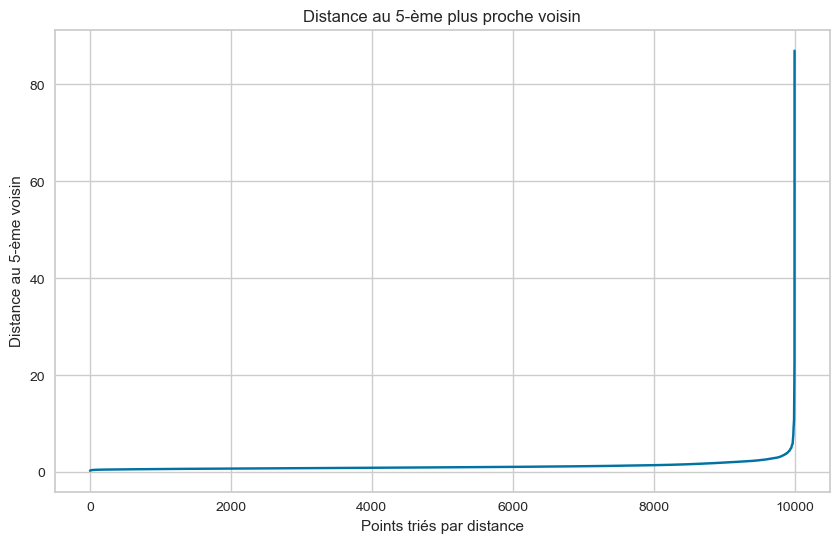


Epsilon choisi pour DBSCAN: 2.8755
Nombre de clusters trouvés par DBSCAN: 7
Pourcentage de points considérés comme bruit: 0.61%

Distribution des clients par cluster (DBSCAN):
Bruit: 585 clients (0.61%)
Cluster 0: 92802 clients (96.57%)
Cluster 1: 2562 clients (2.67%)
Cluster 2: 121 clients (0.13%)
Cluster 3: 9 clients (0.01%)
Cluster 4: 5 clients (0.01%)
Cluster 5: 7 clients (0.01%)
Cluster 6: 5 clients (0.01%)


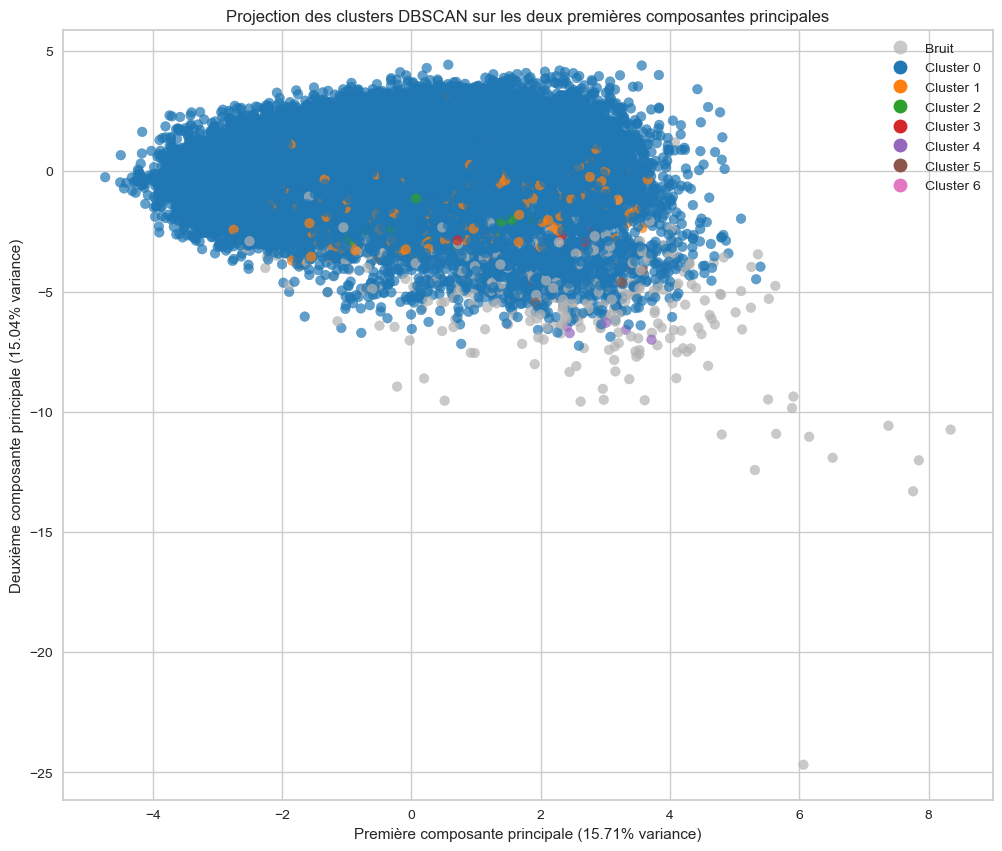

In [15]:
# Calculer les distances au k-ème plus proche voisin (k=5) sur un échantillon si nécessaire
def compute_optimal_epsilon(X_data, k=5, sample_size=10000, plot=True):
    """
    Calcule la distance optimale (epsilon) pour DBSCAN en analysant
    les distances au k-ème plus proche voisin.
    
    Parameters:
    -----------
    X_data : array-like
        Données à analyser
    k : int, default=5
        Nombre de voisins à considérer
    sample_size : int, default=10000
        Taille de l'échantillon à utiliser si les données sont trop grandes
    plot : bool, default=True
        Si True, affiche le graphique des distances
        
    Returns:
    --------
    epsilon : float
        Valeur d'epsilon recommandée
    sample_indices : array
        Indices de l'échantillon utilisé
    """
    # Échantillonnage si nécessaire
    sample_size_knn = min(sample_size, len(X_data))
    if len(X_data) > sample_size:
        np.random.seed(42)  # Pour la reproductibilité
        sample_indices_knn = np.random.choice(len(X_data), size=sample_size_knn, replace=False)
    else:
        sample_indices_knn = np.arange(len(X_data))
    
    X_sample_knn = X_data[sample_indices_knn]
    
    # Calcul des distances
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(X_sample_knn)
    distances, indices = neigh.kneighbors(X_sample_knn)
    distances = np.sort(distances[:, k-1])
    
    # Visualisation pour trouver le "coude" dans les distances
    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(distances)
        plt.title(f'Distance au {k}-ème plus proche voisin')
        plt.xlabel('Points triés par distance')
        plt.ylabel(f'Distance au {k}-ème voisin')
        plt.grid(True)
        plt.show()
        plt.close()
    
    # Choisir epsilon au niveau du "coude" (97ème percentile)
    epsilon = np.percentile(distances, 97)
    print(f"\nEpsilon choisi pour DBSCAN: {epsilon:.4f}")
    
    return epsilon, sample_indices_knn

def apply_dbscan(X_data, epsilon, min_samples=5):
    """
    Applique l'algorithme DBSCAN aux données.
    
    Parameters:
    -----------
    X_data : array-like
        Données à clusteriser
    epsilon : float
        Paramètre epsilon pour DBSCAN
    min_samples : int, default=5
        Nombre minimum de points pour former un cluster
        
    Returns:
    --------
    dbscan : DBSCAN
        Modèle DBSCAN entraîné
    dbscan_labels : array
        Étiquettes de cluster pour chaque point
    """
    # Appliquer DBSCAN
    dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
    dbscan_labels = dbscan.fit_predict(X_data)
    
    # Nombre de clusters trouvés par DBSCAN (sans compter le bruit = -1)
    n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    print(f"Nombre de clusters trouvés par DBSCAN: {n_clusters_dbscan}")
    
    # Pourcentage de points considérés comme bruit
    noise_percentage = 100 * list(dbscan_labels).count(-1) / len(dbscan_labels)
    print(f"Pourcentage de points considérés comme bruit: {noise_percentage:.2f}%")
    
    return dbscan, dbscan_labels

def analyze_dbscan_clusters(X_data, dbscan_labels):
    """
    Analyse la distribution des clusters DBSCAN.
    
    Parameters:
    -----------
    X_data : array-like
        Données d'origine
    dbscan_labels : array
        Étiquettes de cluster pour chaque point
    """
    # Distribution des tailles des clusters pour DBSCAN
    dbscan_cluster_sizes = pd.Series(dbscan_labels).value_counts().sort_index()
    print("\nDistribution des clients par cluster (DBSCAN):")
    for cluster, size in dbscan_cluster_sizes.items():
        if cluster == -1:
            print(f"Bruit: {size} clients ({size/len(X_data)*100:.2f}%)")
        else:
            print(f"Cluster {cluster}: {size} clients ({size/len(X_data)*100:.2f}%)")

def visualize_dbscan_clusters(X_pca_2d, dbscan_labels, pca_obj=None):
    """
    Visualise les clusters DBSCAN dans l'espace PCA 2D.
    
    Parameters:
    -----------
    X_pca_2d : array-like
        Données projetées dans l'espace PCA 2D
    dbscan_labels : array
        Étiquettes de cluster pour chaque point
    pca_obj : PCA, default=None
        Objet PCA utilisé pour la projection
    """
    # Déterminer le nombre de clusters (sans compter le bruit)
    unique_labels = set(dbscan_labels)
    n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
    
    # Créer une colormap appropriée
    cmap = cm.get_cmap('tab10', max(10, n_clusters + 1))
    
    # Création d'un mapping pour les couleurs
    # Le bruit est toujours en gris, les clusters sont colorés
    colors = []
    for label in dbscan_labels:
        if label == -1:
            colors.append([0.7, 0.7, 0.7, 0.5])  # Gris pour le bruit
        else:
            # S'assurer que l'index est dans la plage valide
            color_idx = label % 10  # Limiter à 10 couleurs maximum
            colors.append(cmap(color_idx))
    
    # Visualisation des clusters DBSCAN
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=colors, alpha=0.7)
    
    # Créer une légende personnalisée
    legend_elements = []
    for label in sorted(unique_labels):
        if label == -1:
            legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', 
                                               markerfacecolor=[0.7, 0.7, 0.7, 0.7], 
                                               markersize=10, label='Bruit'))
        else:
            color_idx = label % 10
            legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', 
                                               markerfacecolor=cmap(color_idx), 
                                               markersize=10, label=f'Cluster {label}'))
    
    plt.legend(handles=legend_elements, loc='upper right')
    
    if pca_obj is not None:
        plt.xlabel(f'Première composante principale ({pca_obj.explained_variance_ratio_[0]:.2%} variance)')
        plt.ylabel(f'Deuxième composante principale ({pca_obj.explained_variance_ratio_[1]:.2%} variance)')
    else:
        plt.xlabel('Première composante principale')
        plt.ylabel('Deuxième composante principale')
    
    plt.title('Projection des clusters DBSCAN sur les deux premières composantes principales')
    plt.grid(True)
    plt.show()
    plt.close()

# Utilisation
# 1. Calculer epsilon optimal
epsilon, sample_indices_knn = compute_optimal_epsilon(X_pca_reduced, k=5)

# 2. Appliquer DBSCAN
dbscan, dbscan_labels = apply_dbscan(X_pca_reduced, epsilon, min_samples=5)

# 3. Analyser les clusters
analyze_dbscan_clusters(X_pca_reduced, dbscan_labels)

# 4. Visualiser les clusters
# Réduction de dimension avec PCA (si ce n'est pas déjà fait)
if 'X_pca_2d' not in locals():
    pca_2d = PCA(n_components=2)
    X_pca_2d = pca_2d.fit_transform(X_pca_reduced)
    
visualize_dbscan_clusters(X_pca_2d, dbscan_labels, pca_obj=pca_2d)

Analyse du graphique de distance au 5ème plus proche voisin

Le graphique fourni illustre la distribution des distances au 5ème plus proche voisin pour l'ensemble des points, trié par ordre croissant. Cette visualisation est cruciale pour déterminer la valeur optimale du paramètre epsilon dans l'algorithme DBSCAN.
- Croissance lente et régulière pour environ 99% des points (presque horizontale)
- Augmentation exponentielle pour environ 1% des points aux extrémités
- Point d'inflexion (coude) peu prononcé autour du 9800ème point
- Valeur d'epsilon choisie (2,8755) correspondant approximativement à ce point d'inflexion

Analyse de la segmentation DBSCAN
L'application de DBSCAN révèle des limitations majeures pour une utilisation en marketing :
- Déséquilibre extrême des segments : un seul cluster massif regroupant plus de 96% des clients, rendant la segmentation pratiquement inutile pour des actions marketing différenciées. La granularité est insuffisante pour identifier des comportements clients distincts au sein de cette masse

- Problème des micro-clusters
5 micro-clusters comptant chacun entre 5 et 121 clients représentent des segments statistiquement non significatifs. Ces groupes sont trop petits pour justifier des stratégies marketing dédiées et pourraient simplement représenter des valeurs aberrantes

## Comparatif des algorithmes

- K-means (6 clusters) : distribution équilibrée (entre 3% et 39% par segment) avec une bonne stabilité (ARI moyen de 0,879)
- CAH (6 clusters) : déséquilibre notable (segment dominant à 49%) et un segment non significatif, mais restait plus exploitable que DBSCAN
- DBSCAN (7 clusters) : Produit un segment ultra-dominant (97%) rendant la segmentation inefficace pour le marketing

K-means avec 6 clusters est la solution optimale.

# Validation de la qualité du clustering

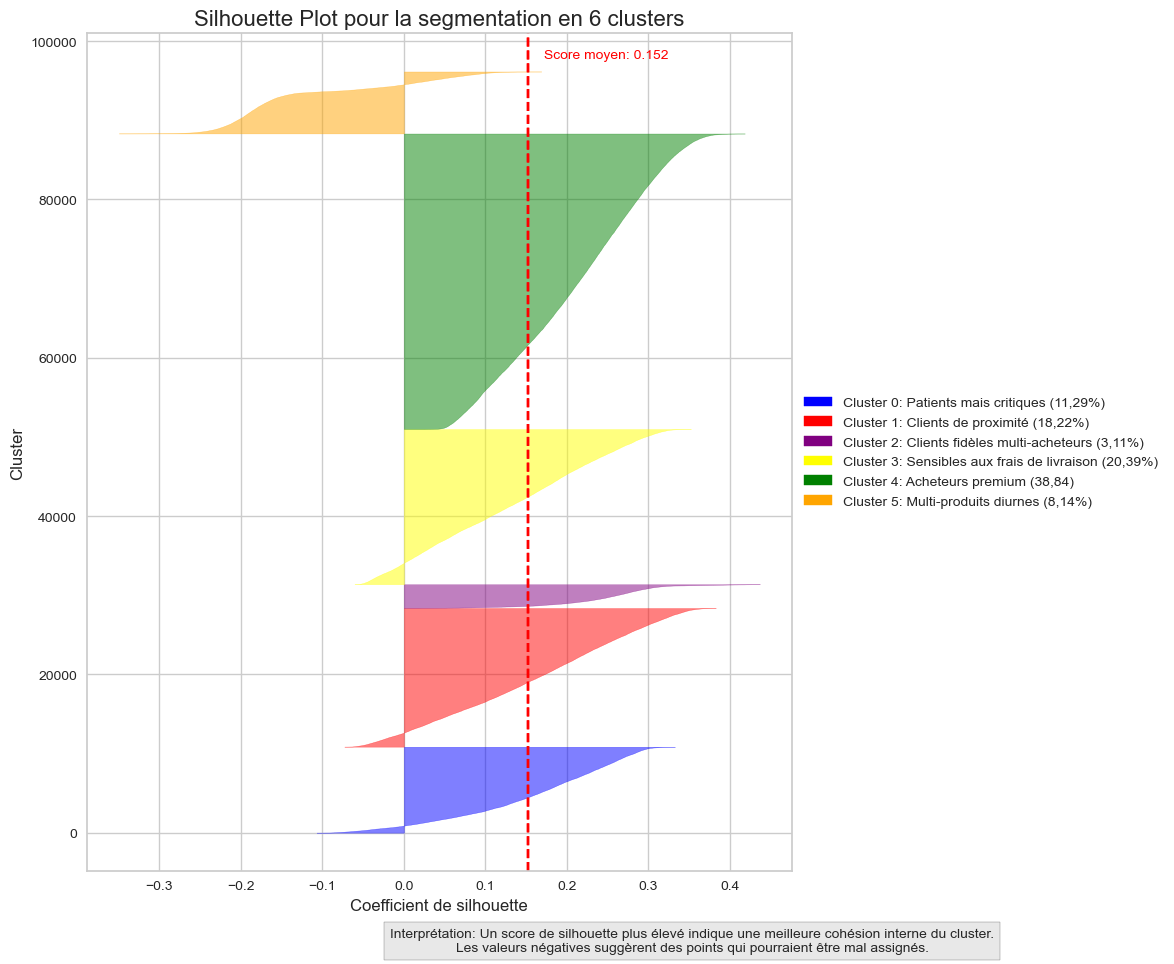

In [16]:
# Validation de la stabilité des clusters avec la méthode de silhouette
from yellowbrick.cluster import SilhouetteVisualizer
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Créer une figure avec une taille suffisante
fig, ax = plt.subplots(1, 1, figsize=(14, 10))

# Définir une palette de couleurs cohérente avec votre projection PCA
colors = ['blue', 'red', 'purple', 'yellow', 'green', 'orange']

# Initialiser le visualiseur de silhouette
visualizer = SilhouetteVisualizer(kmeans_6, ax=ax, colors=colors)
visualizer.fit(X_pca_reduced)

# Modifier le titre et les labels
ax.set_title('Silhouette Plot pour la segmentation en 6 clusters', fontsize=16)
ax.set_xlabel('Coefficient de silhouette', fontsize=12)
ax.set_ylabel('Cluster', fontsize=12)

# Définir les noms des clusters
cluster_names = [
    "Patients mais critiques (11,29%)",
    "Clients de proximité (18,22%)",
    "Clients fidèles multi-acheteurs (3,11%)",
    "Sensibles aux frais de livraison (20,39%)",
    "Acheteurs premium (38,84)",
    "Multi-produits diurnes (8,14%)"
]

# Créer une légende personnalisée avec les couleurs et les noms des clusters
legend_elements = []
for i, (color, name) in enumerate(zip(colors, cluster_names)):
    legend_elements.append(
        mpatches.Patch(color=color, label=f"Cluster {i}: {name}")
    )

# Ajouter la légende à droite du graphique
ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)

# Ajouter une ligne verticale pour le score moyen
mean_silhouette = visualizer.silhouette_score_
ax.axvline(x=mean_silhouette, color='red', linestyle='--')
ax.text(mean_silhouette+0.02, ax.get_ylim()[1]*0.98, 
        f'Score moyen: {mean_silhouette:.3f}', 
        color='red', fontsize=10, verticalalignment='top')

# Ajouter une note explicative
note = ("Interprétation: Un score de silhouette plus élevé indique une meilleure cohésion interne du cluster.\n"
        "Les valeurs négatives suggèrent des points qui pourraient être mal assignés.")
plt.figtext(0.5, 0.01, note, ha='center', fontsize=10, bbox={"facecolor":"lightgray", "alpha":0.5})

# Ajuster la mise en page pour accommoder la légende
plt.tight_layout(rect=[0, 0.03, 0.85, 0.97])

plt.show()

Visualisation des coefficients de silhouette par cluster pour évaluer la qualité de la segmentation à 6 clusters. Le graphique montre des coefficients majoritairement positifs pour tous les clusters.

Analyse

Le silhouette plot présenté illustre la qualité de l'attribution des clients aux 6 clusters identifiés, avec un score moyen de 0,152 - une valeur faible mais positive qui confirme la validité globale de la segmentation.
Le graphique montre que :
- La majorité des points présentent des coefficients positifs dans tous les clusters
- Chaque segment possède une "forme" de silhouette distinctive reflétant sa cohérence interne
- Des valeurs négatives existent mais restent minoritaires dans l'ensemble des clusters



Cluster 4: Acheteurs premium (38,84%) - Vert
-  Distribution étendue des scores avec valeurs atteignant 0,4
- Scores majoritairement positifs malgré quelques valeurs négatives marginales
- Remarquable cohésion pour un segment aussi volumineux (près de 40% des clients)
La largeur du segment sur le graphique confirme sa position dominante dans la base clients

Ce segment majoritaire présente une solidité statistique qui justifie sa position centrale dans la stratégie marketing. La qualité de sa définition assure la pertinence des initiatives premium ciblées.



Cluster 3: Sensibles aux frais de livraison (20,39%) - Jaune
-  Distribution favorable avec peu de valeurs négatives
- Deuxième segment en importance présentant une définition claire
- Profil de silhouette plus étroit mais bien défini dans la zone positive
- Légère asymétrie suggérant une distinction nette vis-à-vis des autres segments

La cohérence de ce segment confirme la validité des stratégies centrées sur l'optimisation des frais de livraison et constitue une base solide pour les initiatives d'augmentation du panier moyen.



Cluster 1: Clients de proximité (18,22%) - Rouge
- Silhouette équilibrée avec distribution homogène des scores positifs
- Cohésion interne satisfaisante confirmant la pertinence de ce segment intermédiaire
- Quelques valeurs très positives (>0,3) indiquant des clients parfaitement alignés au profil

Ce segment offre une base solide pour des campagnes géolocalisées et des stratégies logistiques différenciées, sa cohérence validant l'approche marketing territoriale.



Cluster 0: Patients mais critiques (11,29%) - Bleu
- Silhouette compacte mais majoritairement dans la zone positive
- Scores concentrés entre 0 et 0,3 avec quelques valeurs négatives
-  Cohésion modérée suggérant un segment distinct mais avec certaines zones d'ambiguïté

La distribution des scores justifie une approche différenciée selon la position du client dans ce segment, avec un focus particulier sur l'amélioration de la satisfaction via une meilleure gestion des attentes.



Cluster 5: Multi-produits diurnes (8,14%) - Orange
- Distribution favorable mais avec une partie significative de scores faiblement positifs
- Segment présentant une définition correcte malgré sa taille modeste
- Zone de chevauchement potentiel avec d'autres segments

La présence de scores plus modestes suggère un segment légèrement moins homogène, ce qui pourrait nécessiter des tests marketing préalables pour optimiser l'efficacité des actions ciblées.



Cluster 2: Clients fidèles multi-acheteurs (3,11%) - Violet
- Scores de silhouette parmi les plus élevés malgré quelques valeurs négatives
- Segment minoritaire présentant une remarquable isolation statistique
- Profil compact reflétant sa distinction comportementale claire

Ce petit segment extrêmement bien défini constitue une base idéale pour un programme de fidélité VIP à forte valeur ajoutée et peut servir de "laboratoire" pour tester de nouvelles offres premium.

In [17]:
print(cluster_means_6.columns)

Index(['recence_scaled', 'frequence_scaled', 'avg_review_log_std',
       'avg_product_price_log_std', 'avg_basket_items_log_std', 'day_0',
       'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'hour_night',
       'hour_morning', 'hour_afternoon', 'hour_evening', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12',
       'avg_delivery_time_log_std', 'freight_ratio_std',
       'avg_distance_km_log_std'],
      dtype='object')


Affichage des colonnes disponibles dans le DataFrame des moyennes par cluster, confirmant l'accès à toutes les variables utilisées pour caractériser les segments.

## Radar chart

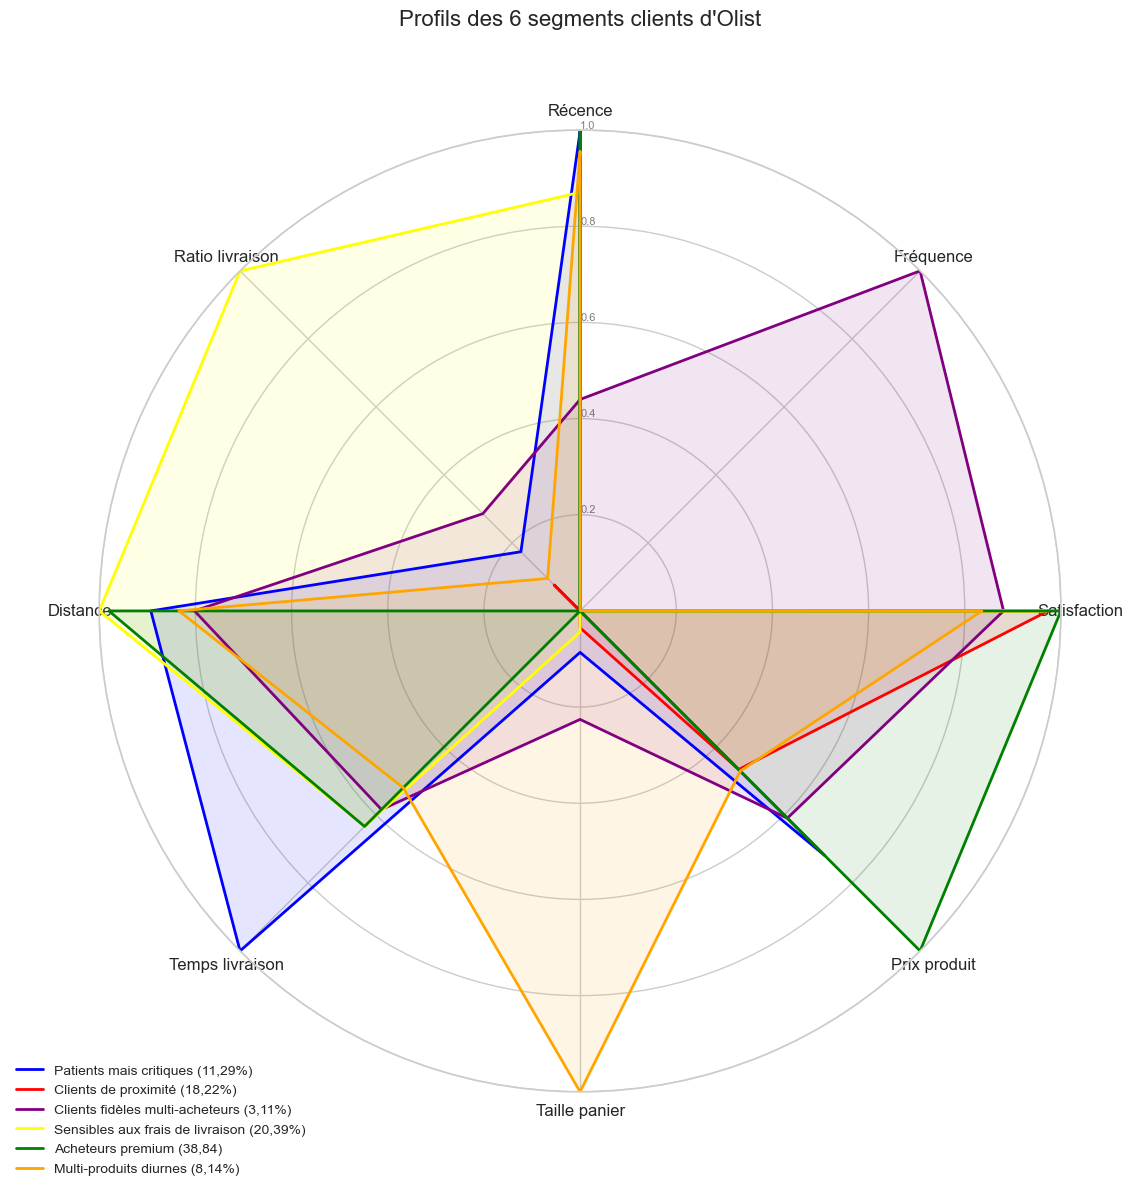

In [20]:
# Sélection des variables clés RFM et comportementales
key_features = [
    'recence_scaled',             # Récence
    'frequence_scaled',           # Fréquence
    'avg_review_log_std',         # Satisfaction client
    'avg_product_price_log_std',  # Prix moyen des produits
    'avg_basket_items_log_std',   # Taille du panier
    'avg_delivery_time_log_std',  # Temps de livraison
    'avg_distance_km_log_std',    # Distance géographique
    'freight_ratio_std'           # Ratio frais de livraison/montant
]

# Mise en forme des noms des variables pour l'affichage
display_names = [
    'Récence',
    'Fréquence',
    'Satisfaction',
    'Prix produit',
    'Taille panier',
    'Temps livraison',
    'Distance',
    'Ratio livraison'
]

# Noms descriptifs des clusters avec pourcentages
cluster_names = [
    "Patients mais critiques (11,29%)",
    "Clients de proximité (18,22%)",
    "Clients fidèles multi-acheteurs (3,11%)",
    "Sensibles aux frais de livraison (20,39%)",
    "Acheteurs premium (38,84)",
    "Multi-produits diurnes (8,14%)"
]

# Couleurs cohérentes avec les autres visualisations
cluster_colors = [
    'blue',     # Cluster 0: Acheteurs premium
    'red',       # Cluster 1: Clients de proximité  
    'purple',        # Cluster 2: Multi-produits diurnes
    'yellow',  # Cluster 3: Patients mais critiques
    'green',      # Cluster 4: Sensibles aux frais de livraison
    'orange'        # Cluster 5: Clients fidèles multi-acheteurs    
]

# Normalization des données pour le radar chart
def normalize_for_radar(df, features):
    df_normalized = df.copy()
    for feature in features:
        min_val = df[feature].min()
        max_val = df[feature].max()
        df_normalized[feature] = (df[feature] - min_val) / (max_val - min_val)
    return df_normalized

# Obtenir les moyennes normalisées par cluster
cluster_means_normalized = normalize_for_radar(cluster_means_6, key_features)

# Création du radar chart
def radar_chart(means_norm, features, display_names, cluster_names, colors, title):
    # Nombre de variables
    N = len(features)
    
    # Calculer les angles pour chaque variable
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]  # Fermer le cercle
    
    # Initialiser la figure
    fig, ax = plt.subplots(figsize=(14, 12), subplot_kw=dict(polar=True))
    
    # Ajouter chaque cluster
    for i in range(len(means_norm)):
        values = means_norm.loc[i, features].values.tolist()
        values += values[:1]  # Fermer le cercle
        
        # Tracer la ligne et remplir l'aire
        ax.plot(angles, values, linewidth=2, linestyle='solid', color=colors[i], label=cluster_names[i])
        ax.fill(angles, values, alpha=0.1, color=colors[i])
    
    # Configurer les axes et les grilles
    ax.set_theta_offset(pi / 2)  # Commencer par le haut
    ax.set_theta_direction(-1)   # Sens horaire
    
    # Configurer les grilles circulaires
    ax.set_rlabel_position(0)
    plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["0.2", "0.4", "0.6", "0.8", "1.0"], color="grey", size=8)
    plt.ylim(0, 1)
    
    # Étiquettes des caractéristiques
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(display_names, size=12)
    
    # Ajouter une légende avec des couleurs cohérentes
    plt.legend(loc='lower left', bbox_to_anchor=(-0.1, -0.1), fontsize=10)
    
    # Ajouter un titre
    plt.title(title, size=16, y=1.1)
    
    plt.tight_layout()
    plt.show()
    plt.close()

# Générer le radar chart avec les noms et couleurs
radar_chart(
    cluster_means_normalized, 
    key_features, 
    display_names, 
    cluster_names, 
    cluster_colors,
    'Profils des 6 segments clients d\'Olist'
)

Le radar chart présenté offre une visualisation multidimensionnelle des "signatures comportementales" de chaque segment client sur 7 dimensions clés (récence, fréquence, satisfaction, prix produit, taille panier, temps livraison, distance, ratio livraison). Cette représentation graphique permet d'identifier instantanément les caractéristiques distinctives de chaque groupe.

Analyse

Segment "Acheteurs premium" (38,84% - vert)
- Signature comportementale: Triangle fortement étiré vers les prix élevés et la satisfaction client
- Forces distinctives:
    - Prix d'achat significativement supérieurs à tous les autres segments
    - Satisfaction client parmi les plus élevées
    - Bon équilibre entre distance géographique et temps de livraison
- Opportunités:
    - Potentiel d'augmentation de la fréquence d'achat qui reste modérée
    - Ratio frais de livraison favorable permettant des offres premium supplémentaires

Ce segment majoritaire représente l'épine dorsale économique d'Olist avec un profil client idéal combinant pouvoir d'achat élevé et satisfaction importante.



Segment "Clients de proximité" (18,22% - rouge)
- Signature comportementale: Forme équilibrée avec pointe marquée vers la satisfaction
- Forces distinctives:
    - Excellence logistique avec distances minimales et délais courts
    - Meilleur niveau de satisfaction client
    - Faible ratio de frais livraison/prix renforçant l'expérience positive
- Opportunités:
    - Base solide pour des stratégies de fidélisation locales
    - Potentiel d'augmentation de la taille du panier et de la fréquence d'achat

Ce segment présente le meilleur équilibre global entre toutes les dimensions, ce qui en fait une base particulièrement stable pour des initiatives marketing géolocalisées.



Segment "Clients fidèles multi-acheteurs" (3,11% - violet)
- Signature comportementale: Forme extrêmement déséquilibrée avec pic spectaculaire sur la fréquence
- Forces distinctives:
    - Fréquence d'achat exceptionnelle, dépassant de loin tous les autres segments
    - Bon niveau de satisfaction
    - Valeur vie client très élevée malgré la taille réduite du segment
- Opportunités:
    - Profil idéal pour un programme de fidélité VIP
    - Potentiel d'ambassadeurs de marque et de prescripteurs

Ce micro-segment hautement spécifique représente l'élite de la clientèle en termes de fidélité et justifie des investissements marketing ciblés malgré sa taille réduite.



Segment "Patients mais critiques" (11,29% - bleu)
- Signature comportementale: Forme déséquilibrée avec pics sur le temps de livraison et la récence
- Points critiques:
    - Combinaison problématique de temps de livraison maximum et satisfaction minimum
    - Distances importantes contribuant aux délais logistiques étendus
    - Récence élevée suggérant un risque d'attrition après expérience négative
- Défis stratégiques:

- Interventions prioritaires pour éviter la perte de clients
- Nécessité de mieux gérer les attentes en matière de délais
- Zone de vigilance pour la réputation de la plateforme



Ce segment présente le profil le plus problématique, nécessitant une attention particulière pour éviter les effets négatifs sur l'image de marque d'Olist.


Segment "Sensibles aux frais de livraison" (20,39% - jaune)
- Signature comportementale: Forme distinctive étirée vers le ratio de frais de livraison et la distance
- Caractéristiques distinctives:
    - Ratio frais livraison/prix exceptionnellement élevé
    - Combinaison de distances importantes et de prix d'achat minimaux
    - Satisfaction relativement bonne malgré ce déséquilibre structurel
- Enjeux spécifiques:
    - Optimisation urgente de la structure tarifaire de livraison
    - Stratégies pour augmenter la valeur du panier afin d'amortir les frais



Deuxième segment en importance, il représente un enjeu économique majeur pour Olist en raison du déséquilibre entre coûts logistiques et valeur d'achat.
Segment "Multi-produits diurnes" (8,14% - orange)
- Signature comportementale: Forme distinctive avec pic prononcé sur la taille du panier
- Particularités notables:
    - Paniers exceptionnellement volumineux, signature unique du segment
    - Positionnement intermédiaire sur la plupart des autres dimensions
    - Satisfaction correcte mais avec potentiel d'amélioration
- Perspectives de développement:
    - Segment idéal pour des stratégies d'upselling et de cross-selling
    - Potentiel de transition vers le segment premium via des offres ciblées

Ce segment de niche présente une valeur unitaire par transaction élevée et constitue un terrain fertile pour des stratégies marketing avancées.

# Interprétation et description métier des clusters

Exportation du modèle

In [22]:
# Préparation à l'exportation du modèle et des données segmentées
# Ajouter le nom du segment à chaque client
df_6clusters['segment_name'] = df_6clusters['cluster'].map(segment_descriptions)

# Exportation du DataFrame avec les segments pour utilisation ultérieure
df_6clusters.to_csv('olist_client_segments.csv', index=True)

# Code pour l'exportation du modèle (pour l'étape 4)
import joblib
joblib.dump(kmeans_6, 'kmeans_olist_6clusters.pkl')
joblib.dump(pca, 'pca_olist.pkl')

['pca_olist.pkl']

Finalisation du processus de clustering avec l'exportation du modèle K-means et des données segmentées pour utilisation en étape 4 d'analyse de stabilité temporelle. Cette exportation comprend à la fois les identifiants numériques des clusters et leurs noms métier descriptifs

## Assigner de nouveaux clients aux segments existants

In [24]:
# Définition d'une fonction pour assigner de nouveaux clients aux segments existants
def predict_segment_for_new_client(new_client_data):
    """
    Prédit le segment d'un nouveau client en utilisant le modèle entraîné.
    
    Parameters:
    -----------
    new_client_data : DataFrame
        DataFrame contenant les données du nouveau client avec les mêmes features
        que celles utilisées pour l'entraînement.
        
    Returns:
    --------
    segment : int
        Numéro du segment prédit (0-5)
    segment_name : str
        Nom du segment prédit
      
    """
    # Vérifier que toutes les colonnes nécessaires sont présentes
    required_columns = features_clustering.copy()
    missing_columns = set(required_columns) - set(new_client_data.columns)
    if missing_columns:
        raise ValueError(f"Colonnes manquantes: {missing_columns}")
    
    # Prétraitement des données (mêmes transformations que pour l'entraînement)
    client_features = new_client_data[required_columns].copy()
    
    # Appliquer la réduction de dimensionnalité avec la même ACP
    client_pca = pca.transform(client_features)
    
    # Prédire le cluster avec K-means
    cluster = kmeans_6.predict(client_pca)[0]
    
    # Attribuer le nom du segment
    segment_descriptions = {
    0: "Patients mais critiques",
    1: "Clients de proximité",
    2: "Clients fidèles multi-acheteurs",
    3: "Sensibles aux frais de livraison",
    4: "Acheteurs premium",
    5: "Multi-produits diurnes"
    }
    segment_name = segment_descriptions[cluster]
    
    return cluster, segment_name

# Création d'un exemple de nouveau client

# Créer un DataFrame vide avec les mêmes colonnes que celles utilisées pour le clustering
new_client = pd.DataFrame(columns=features_clustering)

# Les valeurs sont basées sur la description d'un client susceptible d'être "Acheteurs premium"
new_client_data = {
    'recence_scaled': 0.1,                   # Récence moyenne légèrement supérieure (achat récent)
    'frequence_scaled': -0.175,              # Fréquence d'achat faible (typique des acheteurs premium)
    'avg_review_log_std': 0.5,               # Score de satisfaction élevé
    'avg_product_price_log_std': 1.2,        # Prix moyen des produits élevé
    'avg_basket_items_log_std': -0.3,        # Peu d'articles par panier
    'avg_delivery_time_log_std': 0.0,        # Temps de livraison moyen
    'freight_ratio_std': -0.2,               # Ratio frais/montant moyen-bas
    'avg_distance_km_log_std': 0.7,          # Distance client-vendeur importante
    
    # Jours de la semaine (plus d'achats le weekend)
    'day_0': 0, 'day_1': 0, 'day_2': 0, 'day_3': 0, 'day_4': 0, 'day_5': 1, 'day_6': 1,
    
    # Heures de la journée
    'hour_night': 0, 'hour_morning': 0, 'hour_afternoon': 1, 'hour_evening': 0,
    
    # Mois (distribution uniforme)
    'month_1': 0, 'month_2': 0, 'month_3': 0, 'month_4': 0, 'month_5': 0, 
    'month_6': 0, 'month_7': 0, 'month_8': 1, 'month_9': 0, 'month_10': 0,
    'month_11': 0, 'month_12': 0
}

# Créer le DataFrame avec une seule ligne
new_client = pd.DataFrame([new_client_data])

# Utilisation avec notre nouveau client fictif
print("Exemple d'utilisation de la fonction de prédiction pour un nouveau client:")
print("Nous avons un nouveau client avec les données suivantes:")
print("- Fréquence d'achat faible")
print("- Score de satisfaction élevé")
print("- Prix moyen des produits élevé")
print("- Peu d'articles par panier")
print("- Temps de livraison moyen")
print("- Distance client-vendeur importante")
print("- Achats plutôt le week-end")
print("\nCe client correspond au profil d'un 'Acheteur de Produits Premium'")

# Faire la prédiction
try:
    cluster, segment = predict_segment_for_new_client(new_client)
    print(f"\nRésultat de la prédiction :")
    print(f"Le client a été assigné au segment {cluster}: {segment}")
except Exception as e:
    print(f"\nErreur lors de la prédiction: {e}")
    print("Pour utiliser cette fonction en production, assurez-vous que:")
    print("1. Les modèles 'pca' et 'kmeans_6' sont correctement définis et entraînés")
    print("2. La variable 'features_clustering' contient la liste des features utilisées")
    print("3. Toutes les transformations nécessaires sont appliquées aux nouvelles données")

Exemple d'utilisation de la fonction de prédiction pour un nouveau client:
Nous avons un nouveau client avec les données suivantes:
- Fréquence d'achat faible
- Score de satisfaction élevé
- Prix moyen des produits élevé
- Peu d'articles par panier
- Temps de livraison moyen
- Distance client-vendeur importante
- Achats plutôt le week-end

Ce client correspond au profil d'un 'Acheteur de Produits Premium'

Résultat de la prédiction :
Le client a été assigné au segment 4: Acheteurs premium


Le système de prédiction a correctement identifié ce nouveau client comme appartenant au segment "Acheteurs premium" (segment 4), démontrant l'efficacité opérationnelle de notre modèle de segmentation.